# 基于LangGraph的智能深度研究代理

## 需求分析

在当今信息爆炸的时代，研究人员、学生和分析师在进行深度课题研究时面临着严峻的挑战。传统的“人工研究”模式存在以下痛点：

1. **耗时巨大 (Time-Consuming)**: 手动搜索、筛选、阅读和整合大量文献资料是一个极其耗时的过程，占据了研究人员大部分的精力。
2. **信息过载 (Information Overload)**: 面对海量的网络信息，如何快速识别高质量、高相关性的内容成为一大难题。研究者容易迷失在信息的海洋中，效率低下。
3. **综合困难 (Difficulty in Synthesis)**: 将来自不同来源、不同视角的信息进行有效整合，形成一个逻辑清晰、观点明确的综合报告，对研究者的认知能力要求极高，且容易产生主观偏见。
4. **交互性差 (Poor Interactivity)**: 传统研究工具是单向的。研究者无法与研究过程进行动态交互，例如在初步计划后进行调整，或对中间结果提出反馈。

我们的智能深度研究代理旨在解决以上痛点。它利用大型语言模型（LLM）的强大能力，将复杂的研究任务自动化，通过多轮交互让用户参与和指导研究过程，最终高效地生成一份结构化、有深度的研究报告。

### 系统架构

我们将整个研究流程拆分为多个职责清晰、可复用的智能体节点，并通过 LangGraph 将它们编排为一条闭环的自动化研究链路。

1. **Planner（规划器）**
- **输入**：用户给定的研究目标。  
- **功能**：调用 LLM 将目标转化为结构化研究计划，拆分成若干可执行的子任务。  
- **输出**：更新状态，生成子任务列表。

2. **Task_Splitter（任务分解器）**
- **输入**：完整研究计划。  
- **功能**：将整体研究问题进一步细化，生成针对每个子任务的检索查询。  
- **输出**：结构化的查询请求。

3. **Content_Searcher（内容搜索器）**
- **输入**：结构化查询请求。  
- **功能**：通过搜索接口（如 Tavily API）检索相关网页，获取原始资料链接与摘要。  
- **输出**：原始搜索结果集合。

4. **Content_Enhancer（内容增强器）**
- **输入**：搜索结果。  
- **功能**：提取网页正文、去除干扰信息，保留可供后续加工的核心文本数据。  
- **输出**：初步提取的关键信息集合。

5. **Content_Evaluator（内容评估器）**
- **输入**：提取后的文本信息。  
- **功能**：对信息进行质量评估（如完整性、可信度、覆盖度），若不达标则触发重查流程。  
- **输出**：
  - 若**不合格**：重新回到内容搜索器进行补查。
  - 若**合格**：信息写入最终报告寄存器。

6. **Report_Register（最终报告寄存器）**
- **输入**：质量合格的信息块。  
- **功能**：聚合多个子任务的结果，为生成最终报告做好准备。  
- **输出**：结构化信息集合。

7. **Report_Generator（最终报告生成器）**
- **输入**：整理好的信息集合。  
- **功能**：调用 LLM，将信息转化为结构完备、语言流畅的研究报告初稿。  
- **输出**：研究报告，完成整条深度研究流程。

Generating single mermaid chart


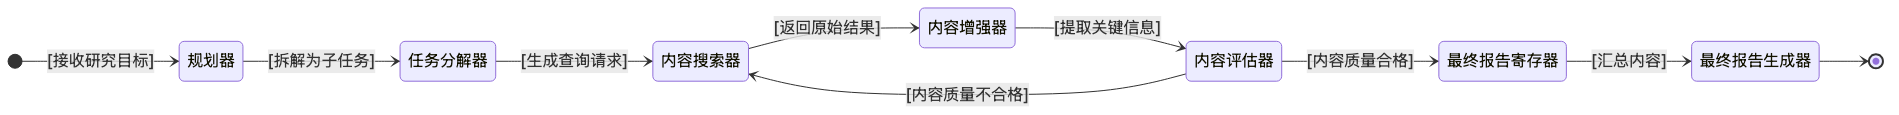

In [24]:
import subprocess, tempfile, os
from IPython.display import Image, display

mermaid_src = r"""
stateDiagram-v2
    direction LR
    [*] --> 规划器: [接收研究目标]
    规划器 --> 任务分解器: [拆解为子任务]
    任务分解器 --> 内容搜索器: [生成查询请求]
    内容搜索器 --> 内容增强器: [返回原始结果]
    内容增强器 --> 内容评估器: [提取关键信息]
    内容评估器 --> 内容搜索器: [内容质量不合格]
    内容评估器 --> 最终报告寄存器: [内容质量合格]
    最终报告寄存器 --> 最终报告生成器: [汇总内容]
    最终报告生成器 --> [*]
"""

with tempfile.TemporaryDirectory() as tmpdir:
    in_file  = os.path.join(tmpdir, "graph.mmd")
    out_file = os.path.join(tmpdir, "graph.png")
    with open(in_file, "w", encoding="utf-8") as f:
        f.write(mermaid_src)

    # 分辨率 ×2（3200×800）；数值可再调大
    subprocess.run(
        ["mmdc", "-i", in_file, "-o", out_file,
         "-b", "transparent", "-w", "3200", "-H", "800"],
        check=True
    )

    # notebook 中按 50% 缩放显示即可更清晰
    display(Image(out_file, width=1600))

In [25]:
!pip install -qU langgraph langchain langchain_openai langchain_community beautifulsoup4 tavily-python

In [26]:
import os
from dotenv import load_dotenv
import operator
from typing import TypedDict, List, Annotated

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import StateGraph, END
from langchain_core.documents import Document
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_BASE"] = os.getenv("OPENAI_API_BASE")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [27]:
class ResearchState(TypedDict):
    """
    代表我们研究图的状态。

    属性:
        current_date (str): 当前日期。
        research_goal (str): 初始的研究课题。
        plan (List[str]): 由规划器生成的子任务列表。
        queries (List[str]): 每个子任务的搜索查询列表。
        search_results (List[dict]): 来自搜索引擎的原始搜索结果。
        raw_content (List[str]): 来自网页的、已清洗的文本内容。
        evaluated_content (List[str]): 由评估器批准的高质量内容集合。
        report (str): 最终的研究报告。
    """
    current_date: str
    research_goal: str
    plan: List[str]
    queries: List[str]
    search_results: List[dict]
    raw_content: List[str]
    evaluated_content: List[str]
    report: str

In [28]:
search_tool = TavilySearchResults(max_results=3)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind(max_tokens=3_000)

In [29]:
import tiktoken

ENC = tiktoken.encoding_for_model("gpt-4o-mini")   # 任何 gpt-4o 系列都行
MAX_TOKENS = 6_000                                  # 单次调用留出回复空间

def chunk_by_tokens(text: str, max_tokens: int = MAX_TOKENS):
    """把长文本按 token 数切片；返回字符串列表。"""
    tokens = ENC.encode(text)
    for i in range(0, len(tokens), max_tokens):
        yield ENC.decode(tokens[i:i + max_tokens])

In [30]:
def planner_node(state: ResearchState) -> dict:
    """规划器节点：将研究目标分解为计划"""
    print(">> [节点] 规划器: 正在生成研究计划...")
    prompt = ChatPromptTemplate.from_template(
        """
        你是一个专业的AI研究规划师。你的任务是为一个只能访问网络进行搜索的自动化代理制定研究计划。

        # 规则与限制:
        1.  计划必须清晰、可执行，并且每个步骤都能转化为一个或多个具体的网络搜索查询。
        2.  计划中不能包含任何需要物理操作、API访问权限或人类访谈的任务。
        3.  计划应包含3到5个核心步骤。
        4.  输出必须是一个Python列表的字符串格式，例如: ["步骤1", "步骤2", ...]。
        5.  今天是 {current_date}，请确保你的计划是基于这个日期的最新视角。

        # 用户研究目标: {research_goal}
        """
    )
    planner_chain = prompt | llm
    plan_string = planner_chain.invoke({"research_goal": state["research_goal"], "current_date": state["current_date"]}).content
    plan = [p for p in plan_string.split("\n") if p.strip()]
    print(f"   - 生成的计划: {plan}")
    return {"plan": plan}

def task_splitter_node(state: ResearchState) -> dict:
    """任务分解器节点：为每个计划步骤生成搜索查询"""
    print(">> [节点] 任务分解器: 正在生成搜索查询...")
    prompt = ChatPromptTemplate.from_template(
        """你是一个AI研究助理。
        请根据以下研究计划中的每个步骤，为其生成一个简洁、有效的搜索引擎查询语句。
        为每个步骤只生成一个查询。
        研究计划:
        {plan}
        
        以如下格式返回，每行一个查询:
        QUERY: [查询语句1]
        QUERY: [查询语句2]
        ..."""
    )
    splitter_chain = prompt | llm
    queries_string = splitter_chain.invoke({"plan": state["plan"]}).content
    queries = [q.replace("QUERY:", "").strip() for q in queries_string.split("\n") if "QUERY:" in q]
    print(f"   - 生成的查询: {queries}")
    return {"queries": queries}

def content_searcher_node(state: ResearchState) -> dict:
    """内容搜索器节点：执行搜索"""
    print(">> [节点] 内容搜索器: 正在执行网络搜索...")
    all_results = []
    for q in state["queries"]:
        for item in search_tool.invoke(q):
            if isinstance(item, str):
                all_results.append({"url": item})
            elif isinstance(item, dict):
                all_results.append({"url": item.get("url", ""), "title": item.get("title", "")})
    return {"search_results": all_results}

def content_enhancer_node(state: ResearchState) -> dict:
    """内容增强器节点：提取网页核心内容"""
    print(">> [节点] 内容增强器: 正在提取网页内容...")
    urls = [r["url"] for r in state["search_results"]][:10]  # 最多 10 个网页
    docs  = WebBaseLoader(urls, continue_on_failure=True).load()

    SUMMARY_PROMPT = ChatPromptTemplate.from_template(
        "请在300词内概括下面网页片段：\n---\n{page}\n---"
    )
    summary_chain = SUMMARY_PROMPT | llm

    summaries = []
    for doc in docs:
        # 先把网页正文分片
        for chunk in chunk_by_tokens(doc.page_content, 4_000):
            summaries.append(summary_chain.invoke({"page": chunk}).content.strip())

    return {"raw_content": summaries}          # 现在存的是网页片段摘要

def content_evaluator_node(state: ResearchState) -> str:
    """内容评估器节点：判断内容质量并决定下一步走向"""
    print(">> [节点] 内容评估器: 正在评估内容质量...")
    EVAL_PROMPT = ChatPromptTemplate.from_template(
        "判断下述摘要是否可信、覆盖研究目标要点。（只答 合格/不合格）\n---\n{frag}\n---"
    )
    eval_chain = EVAL_PROMPT | llm

    # 逐片段打分
    votes = []
    for frag in state["raw_content"]:
        decision = eval_chain.invoke({"frag": frag}).content.strip()
        votes.append("合格" in decision)

    # “多数合格”⇒通过
    result = "合格" if sum(votes) >= len(votes) * 0.6 else "不合格"
    return {"eval_result": result}
    
def report_register_node(state: ResearchState) -> dict:
    """最终报告寄存器节点：聚合高质量内容"""
    print(">> [节点] 最终报告寄存器: 内容质量合格，正在聚合...")
    # 在这个实现中，我们将所有“合格”的内容一次性加入状态中
    return {"evaluated_content": state["raw_content"]}

def report_generator_node(state: ResearchState) -> dict:
    print(">> [节点] 报告生成器: 正在生成最终报告...")

    # ❶ 把所有摘要合并成 ≤10k token 的大块
    merged_blocks = []
    buf = ""
    for frag in state["evaluated_content"]:
        if len(ENC.encode(buf + frag)) > 10_000:
            merged_blocks.append(buf); buf = frag + "\n"
        else:
            buf += frag + "\n"
    merged_blocks.append(buf)

    # ❷ 生成章节提纲
    outline_chain = (
        ChatPromptTemplate.from_template(
            "请基于下方资料列一个详细章节提纲（不少于 10 大点）：\n---\n{info}\n---"
        ) | llm
    )
    outline = outline_chain.invoke({"info": "\n".join(merged_blocks)}).content.split("\n")

    # ❸ 按提纲逐章扩写（每章 400–600 词），再拼接
    section_chain = (
        ChatPromptTemplate.from_template(
            "请根据“章节标题”和“参考资料”撰写 500 词左右的章节内容：\n"
            "章节标题：{title}\n参考资料：\n{info}\n"
        ) | llm
    )
    sections = [
        section_chain.invoke({"title": title, "info": merged_blocks[i % len(merged_blocks)]}).content
        for i, title in enumerate(outline) if title.strip()
    ]

    report = "# 研究报告\n\n" + "\n\n".join(sections)
    return {"report": report}

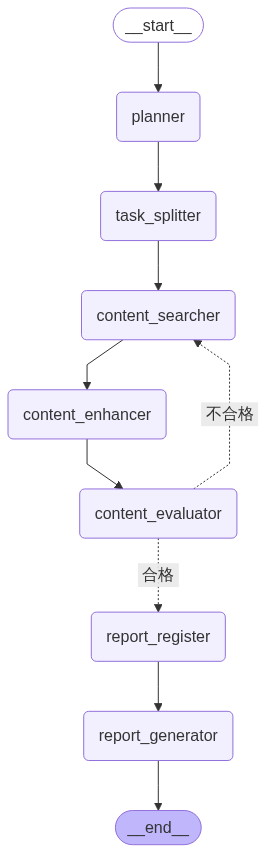

In [31]:
graph_builder = StateGraph(ResearchState)

# 添加所有节点
graph_builder.add_node("planner", planner_node)
graph_builder.add_node("task_splitter", task_splitter_node)
graph_builder.add_node("content_searcher", content_searcher_node)
graph_builder.add_node("content_enhancer", content_enhancer_node)
graph_builder.add_node("content_evaluator", content_evaluator_node)
graph_builder.add_node("report_register", report_register_node)
graph_builder.add_node("report_generator", report_generator_node)

# 设置入口点
graph_builder.set_entry_point("planner")

# 添加边
graph_builder.add_edge("planner", "task_splitter")
graph_builder.add_edge("task_splitter", "content_searcher")
graph_builder.add_edge("content_searcher", "content_enhancer")
graph_builder.add_edge("content_enhancer", "content_evaluator")

# 添加条件边，这是实现循环的关键
graph_builder.add_conditional_edges(
    "content_evaluator",
    lambda st: st["eval_result"],
    path_map={
        "合格": "report_register",
        "不合格": "content_searcher",
    },
)

graph_builder.add_edge("report_register", "report_generator")
graph_builder.add_edge("report_generator", END)

# 编译图，生成可执行的应用
app = graph_builder.compile()

from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [32]:
from pprint import pprint
import datetime

# 定义初始的研究目标
research_goal = "分析2025年人工智能在自动化编程（AI for Code）领域的发展趋势与挑战"
current_date = datetime.date.today().strftime("%Y年%m月%d日")

# 调用图，传入初始状态并开始执行
final_state = app.invoke({"research_goal": research_goal, "current_date": current_date})

# 打印最终生成的研究报告
print("\n" + "="*50)
print("最终研究报告")
print("="*50 + "\n")
pprint(final_state['report'])

>> [节点] 规划器: 正在生成研究计划...
   - 生成的计划: ['["搜索2025年人工智能在自动化编程领域的最新研究论文", "查找2025年人工智能在自动化编程中的应用案例", "分析2025年人工智能在自动化编程面临的主要挑战", "搜索2025年人工智能在自动化编程的市场趋势与预测", "查阅2025年相关行业专家的观点与评论"]']
>> [节点] 任务分解器: 正在生成搜索查询...
   - 生成的查询: ['搜索 2025 年 人工智能 自动化编程 最新研究论文', '查找 2025 年 人工智能 自动化编程 应用案例', '分析 2025 年 人工智能 自动化编程 面临的主要挑战', '搜索 2025 年 人工智能 自动化编程 市场趋势 预测', '查阅 2025 年 相关行业专家 观点 评论']
>> [节点] 内容搜索器: 正在执行网络搜索...
>> [节点] 内容增强器: 正在提取网页内容...
>> [节点] 内容评估器: 正在评估内容质量...
>> [节点] 最终报告寄存器: 内容质量合格，正在聚合...
>> [节点] 报告生成器: 正在生成最终报告...

          最终研究报告

('# 研究报告\n'
 '\n'
 '### 人工智能（AI）技术发展与应用的详细章节提纲\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术经历了前所未有的快速发展，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，DeepMind则通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2具备超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '#### 1. AGI的进展与挑战\n'
 '\n'
 '自2017年Transformer架构问世以来，它成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。然而，尽管AGI的实现不再是遥远的理论问题，但在计算资源、可

In [ ]:
# 数据清洗

In [34]:
raw_content = """

 '# 研究报告\n'
 '\n'
 '### 人工智能（AI）技术发展与应用的详细章节提纲\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术经历了前所未有的快速发展，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，DeepMind则通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2具备超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '#### 1. AGI的进展与挑战\n'
 '\n'
 '自2017年Transformer架构问世以来，它成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。然而，尽管AGI的实现不再是遥远的理论问题，但在计算资源、可解释性和安全对齐等方面仍面临诸多挑战。\n'
 '\n'
 '#### 2. 自动化的广泛应用\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率显著提升。\n'
 '\n'
 '#### 3. AI代理的崛起\n'
 '\n'
 'AI代理的兴起使得AI能够自主执行复杂任务，如AutoGPT可以根据用户目标自动拆解任务并执行，展现出一定的自主性。然而，当前的AI代理仍面临可靠性和决策准确性的问题，尚需进一步改进。尽管AI技术取得了显著进展，但在实现AGI和全面自动化的过程中，仍需克服诸多障碍。\n'
 '\n'
 '#### 4. 伦理与社会影响\n'
 '\n'
 '随着AI技术的快速发展，伦理问题也日益突出。AI的偏见、公平性和版权争议引发广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '#### 5. 未来展望\n'
 '\n'
 '展望未来，AI技术的快速发展正在改变软件开发和创作领域，但同时也带来了新的挑战和伦理问题。2025年，AI工作流程自动化将显著改变企业运营方式，AI代理将成为团队的重要助手，处理从潜在客户生成到报告提交的各类任务。AI的多模态学习、具身智能和安全可信性等领域也备受关注，未来的AI系统需具备更强的理解和适应能力，以应对复杂的现实世界挑战。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。随着技术的不断进步，AI的应用将继续扩展，可能会在更多领域提供支持和帮助。\n'
 '\n'
 '## 第一章 引言\n'
 '\n'
 '在过去的几年中，人工智能（AI）技术经历了前所未有的飞速发展，尤其是在通用人工智能（AGI）和自动化领域。2023至2025年间，顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入了巨额资金，推动了多项技术突破。OpenAI的GPT-4被广泛认为展现了初步的“通用”智能，而DeepMind则通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。与此同时，Anthropic的Claude '
 '2具备超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '自2017年Transformer架构问世以来，它已成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AI的智能化发展，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率得到了显著提升，AI逐渐成为开发团队的标准助手。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，通用人工智能（AGI）和全面自动化的实现仍面临诸多挑战。这些挑战包括计算资源的需求、模型的可解释性、安全对齐等问题。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '2023年，全球对人工智能及其潜在风险的关注显著增加。英国政府主办的全球AI安全峰会提出建立全国性AI安全与标准机构，并发布《布莱切利宣言》，强调AGI可能带来的生存性风险，呼吁国际合作以确保AI安全。与此同时，AI的伦理问题也引发了广泛讨论，包括偏见、公平性和版权争议等。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，技术的快速进步正在改变软件开发和创作领域，同时也带来了新的挑战和伦理问题。社会各界亟需共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，实现人类与AI的和谐共生。随着AI技术的不断演进，未来的社会将面临更多机遇与挑战，如何有效应对这些变化，将是我们必须认真思考的问题。\n'
 '\n'
 '### 1. 人工智能的定义与发展历程\n'
 '\n'
 '人工智能（AI）是计算机科学的一个分支，旨在模拟和实现人类智能的各项功能，包括学习、推理、问题解决、感知和语言理解等。随着技术的不断进步，AI的定义也在不断演变。最初，AI主要集中在特定任务的自动化上，如棋类游戏和简单的逻辑推理。如今，AI的应用已扩展到医疗、金融、教育、交通等多个领域，成为推动社会进步的重要力量。\n'
 '\n'
 '自20世纪50年代以来，人工智能经历了几次重要的发展阶段。早期的AI研究主要集中在符号处理和规则基础的系统上，然而，由于计算能力的限制和对复杂问题的处理能力不足，AI在70年代和80年代经历了一段“寒冬”。进入21世纪，随着计算能力的提升和大数据的普及，AI迎来了新的春天。特别是深度学习技术的兴起，使得AI在图像识别、自然语言处理等领域取得了突破性进展。\n'
 '\n'
 '在2023至2025年间，人工智能技术的进步尤为显著，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，DeepMind则通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。这些进展标志着AI从特定任务向更广泛的智能能力迈进。\n'
 '\n'
 'Transformer架构自2017年问世以来，成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步使得AI能够更好地理解和处理复杂的现实世界问题。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，显著提升了软件开发和创作效率，推动了创意工作的自动化。\n'
 '\n'
 '尽管AI技术取得了显著进展，但在实现通用人工智能（AGI）和全面自动化的过程中，仍面临计算资源、可解释性、安全对齐等挑战。各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '总之，人工智能的定义与发展历程反映了技术的不断演变与社会需求的变化。未来，随着技术的进一步发展，AI将在更多领域发挥重要作用，同时也需要社会各界共同探讨解决面临的挑战。\n'
 '\n'
 '### 2. 2023-2025年间AI技术的显著进展概述\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术经历了前所未有的快速发展，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入了巨额资金，推动了多项技术突破。OpenAI推出的GPT-4被广泛认为展现了初步的“通用”智能，而DeepMind则通过整合团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则以其超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '自2017年Transformer架构问世以来，它已成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在积极探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步使得AI在处理复杂任务时表现得更加灵活和高效。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot被集成到Office应用中，极大提升了办公效率。企业也开始利用AI自动处理客户邮件和生成营销内容，进一步推动了工作流程的智能化。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI的引入使得开发者能够更专注于系统设计和创新，而非重复性任务。\n'
 '\n'
 'AI辅助编程和内容生成技术的迅速发展，显著提升了软件开发和创作效率。AI在软件开发的全生命周期中扮演着重要角色，从产品经理利用对话式AI生成原型界面，到测试工程师自动设计测试用例，再到运维人员通过AI分析故障原因，AI逐渐成为开发团队的标准助手。生成式AI技术的爆发使得文本、图像、音频和视频等内容的创作变得高效，OpenAI的ChatGPT等工具使得内容创作者能够快速生成文章、营销文案和图像，推动了创意工作的自动化。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，AGI的实现和全面自动化的过程中仍面临诸多挑战，包括计算资源、可解释性和安全对齐等问题。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '总的来说，2023至2025年间，AI技术的快速发展正在改变软件开发和创作领域，同时也带来了新的挑战和伦理问题。社会各界亟需共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，推动人类与AI的和谐共生。随着技术的不断进步，AI的应用将继续扩展，可能会在更多领域提供支持和帮助，成为推动社会进步的重要力量。\n'
 '\n'
 '### 3. 研究机构与企业在AGI和自动化领域的角色\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，标志着研究机构与企业在推动这一进程中的重要角色。顶尖研究机构如OpenAI、DeepMind和Anthropic等，凭借其雄厚的资金和技术积累，成为AGI研究的先锋。OpenAI推出的GPT-4被广泛认为是展现初步“通用”智能的里程碑，而DeepMind通过整合团队资源，加速了AGI的研发，推出了代号为“Gemini”的新模型。这些研究机构不仅在技术上取得了突破，也在理论上为AGI的实现奠定了基础。\n'
 '\n'
 '与此同时，企业在AI技术的应用和推广中扮演着不可或缺的角色。微软的Copilot集成到Office应用中，极大地提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。这种AI工具的普及，使得开发者能够将更多精力集中在创新和设计上，而非重复性劳动。\n'
 '\n'
 'AI的进步不仅体现在技术层面，还在于其应用的广泛性。生成式AI技术的爆发，使得文本、图像、音频和视频等内容的创作变得高效，OpenAI的ChatGPT等工具使得内容创作者能够快速生成文章、营销文案和图像，推动了创意工作的自动化。这一趋势不仅提升了生产力，也改变了传统行业的工作方式。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，AGI和全面自动化的实现仍面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题，都是当前研究和应用中亟待解决的难题。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出的《EU '
 'AI法案》便是对此的有力回应，强调对高风险AI系统的监管。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '总之，研究机构与企业在AGI和自动化领域的角色是相辅相成的。研究机构推动技术的前沿发展，而企业则将这些技术应用于实际场景中，推动社会的进步。随着AI技术的不断演进，未来的工作方式和生活方式将会发生深刻变化，社会各界需要共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，实现人类与AI的和谐共生。\n'
 '\n'
 '## 第二章 通用人工智能（AGI）的进展\n'
 '\n'
 '在2023至2025年间，通用人工智能（AGI）的研究和发展取得了显著进展，标志着人工智能技术的一个重要里程碑。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI领域的投入不断增加，推动了多项技术突破，使得AGI的实现不再是遥不可及的梦想。\n'
 '\n'
 'OpenAI的GPT-4被广泛认为展现了初步的“通用”智能，其训练成本高达7835万美元，反映出模型规模和性能的显著提升。GPT-4不仅在自然语言处理方面表现出色，还在多模态学习上展现了潜力，能够处理文本、图像等多种数据形式。与此同时，DeepMind推出的代号为“Gemini”的新模型，通过合并团队和资源，加速了AGI的研发进程，进一步推动了智能体的能力提升。\n'
 '\n'
 '在AGI的进展中，Transformer架构自2017年问世以来，成为了核心驱动力。研究者们正在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的结合使得AI能够更好地理解和处理复杂的现实世界任务，展现出更高的智能水平。\n'
 '\n'
 '自动化领域同样受益于AGI的进展。微软的Copilot集成到Office应用中，极大地提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI的引入使得开发者能够专注于更高层次的设计和创新，而不是重复性的编码工作。\n'
 '\n'
 '然而，尽管AGI的进展令人振奋，仍然面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题亟待解决。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AGI的安全应用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在保护公众利益。\n'
 '\n'
 '伦理问题同样引发了广泛讨论。AI的偏见、公平性和版权争议成为焦点，尤其是在大型模型从互联网上学习时，可能放大社会不平等。艺术家和作家对其作品被用于训练模型而未获补偿表示不满，部分AI公司开始探索内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '总的来说，2023至2025年间，AGI的实现逐渐清晰，AI在各行业的自动化应用不断深化，推动了生产力的提升。尽管面临挑战，AGI的进展为未来的智能社会奠定了基础，促使各方共同探讨解决方案，以确保技术的安全、伦理和社会责任。随着技术的不断演进，AGI将继续塑造我们的生活和工作方式，开启人类与智能体共生的新篇章。\n'
 '\n'
 '### 1. AGI的概念与重要性\n'
 '\n'
 '通用人工智能（AGI）是指一种能够理解、学习和应用知识的智能系统，其能力与人类相当，甚至超越人类。AGI的实现不仅是人工智能研究的终极目标，也是推动社会各领域变革的重要力量。随着2023至2025年间AI技术的迅猛发展，AGI的概念逐渐从理论走向实践，成为各大科技公司和研究机构的重点关注对象。\n'
 '\n'
 '在这一时期，顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI领域投入了巨额资金，推动了多项技术突破。例如，OpenAI的GPT-4被认为展现了初步的“通用”智能，能够处理复杂的语言任务，展现出一定的推理能力。DeepMind则通过整合团队，加速AGI的研发，推出了代号为“Gemini”的新模型，进一步推动了多模态AI的发展。Anthropic的Claude '
 '2则具备超长上下文处理能力，标志着AGI在理解和生成自然语言方面的进步。\n'
 '\n'
 'AGI的重要性不仅体现在技术层面，更在于其对社会经济的深远影响。随着AI在各行业的应用不断深化，AGI的实现将推动生产力的提升，改变传统的工作模式。例如，AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率显著提高。AI在软件开发全生命周期中扮演着重要角色，从产品经理利用对话式AI生成原型界面，到测试工程师自动设计测试用例，再到运维人员通过AI分析故障原因，AI逐渐成为开发团队的标准助手。\n'
 '\n'
 '然而，AGI的实现也伴随着诸多挑战。计算资源的需求、模型的可解释性、安全对齐等问题亟待解决。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和伦理使用。\n'
 '\n'
 '此外，AGI的快速发展引发了对伦理问题的广泛讨论。AI的偏见、公平性和版权争议等问题日益突出，社会各界亟需共同探讨解决方案。AI的自动化虽然提高了效率，但也对传统岗位造成替代压力，尤其是重复性强的白领工作。未来，教育领域需要强调培养AI难以取代的创造性和社交技能，以应对劳动力市场的转型。\n'
 '\n'
 '总之，AGI的概念与重要性在于其不仅是技术发展的前沿，更是社会变革的催化剂。随着技术的不断进步，AGI将为人类带来前所未有的机遇与挑战，推动人类与AI的和谐共生。\n'
 '\n'
 '### 2. OpenAI的GPT-4与其“通用”智能特征\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的飞速发展引发了广泛关注，尤其是在通用人工智能（AGI）领域。OpenAI的GPT-4被认为是这一进程中的重要里程碑，展现了初步的“通用”智能特征。GPT-4的成功不仅源于其庞大的模型规模和高昂的训练成本（高达7835万美元），更在于其在多模态学习和元学习方面的创新。\n'
 '\n'
 'GPT-4的核心架构基于Transformer，这一自2017年问世以来的技术，已成为推动AGI进展的关键驱动力。通过对海量数据的训练，GPT-4能够理解和生成自然语言，处理复杂的上下文信息，展现出超越以往模型的综合认知能力。这种能力使得GPT-4在文本生成、对话系统、内容创作等多个领域表现出色，成为各行业的得力助手。\n'
 '\n'
 '与此同时，AI的自动化应用也在不断扩展。微软的Copilot等工具已被广泛集成到办公软件中，显著提升了工作效率。企业利用AI自动处理客户邮件、生成营销内容，甚至在软件开发中，AI编程助手如GitHub的Copilot也大幅提高了开发者的工作效率，减少了编码和调试的时间。这些应用不仅提升了生产力，也推动了人机协作的新模式。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，通用人工智能的实现仍面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题亟待解决。AI模型的决策过程往往不透明，增加了潜在风险，尤其是在高风险应用场景中。因此，各国政府开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和伦理使用。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。为此，部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '展望未来，AI的快速发展将继续改变软件开发和创作领域，同时也带来了新的挑战和伦理问题。社会各界需要共同探讨解决方案，以确保AI技术的安全、伦理和社会责任。随着技术的不断进步，GPT-4及其后续模型将继续推动AGI的研究与应用，开启人类与AI的和谐共生新篇章。\n'
 '\n'
 '### 3. DeepMind的“Gemini”模型及其研发策略\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展引发了全球范围内的广泛关注，尤其是在通用人工智能（AGI）和自动化领域。作为这一领域的领军者之一，DeepMind推出了代号为“Gemini”的新模型，旨在加速AGI的研发进程。Gemini的推出不仅是技术上的突破，更是DeepMind在研发策略上的重要转变。\n'
 '\n'
 'Gemini模型的核心在于其多模态能力，能够处理文本、图像、音频和视频等多种输入形式。这一特性使得Gemini在理解和生成内容方面展现出卓越的能力，尤其是在编程和复杂任务的执行上。与以往的模型相比，Gemini不仅具备更强的逻辑分析能力，还能在多种场景下进行自我学习和适应，标志着AI技术向更高层次的智能化迈进。\n'
 '\n'
 'DeepMind的研发策略强调团队的整合与协作。通过合并不同领域的专家，DeepMind能够在AGI的研发中实现跨学科的知识共享与技术融合。这种策略不仅提升了研发效率，也为Gemini的多模态能力提供了强有力的支持。团队成员来自机器学习、认知科学、计算机视觉等多个领域，形成了一个多元化的创新环境，推动了Gemini的快速迭代与优化。\n'
 '\n'
 '在技术架构上，Gemini基于Transformer架构，这一自2017年问世以来便成为AGI进展的核心驱动力。随着模型规模的不断扩大，Gemini的训练成本也随之上升，2023年，类似于OpenAI的GPT-4，其训练成本高达7835万美元。这一现象反映了AI模型在性能和规模上的提升，同时也引发了对计算资源和可持续性的关注。\n'
 '\n'
 '除了技术创新，DeepMind还积极应对AI发展带来的伦理和安全挑战。随着AI技术的广泛应用，社会对其潜在风险的关注日益增加。DeepMind在研发Gemini的过程中，始终将安全性和可解释性作为重要考量，力求在推动技术进步的同时，确保其应用的安全与可靠。为此，DeepMind与各国政府和研究机构合作，参与制定相关法律法规，以平衡创新与风险。\n'
 '\n'
 '在自动化领域，Gemini的应用前景同样广阔。AI的自动化能力正在改变企业的运营模式，提升工作效率。Gemini能够自动处理客户邮件、生成营销内容，甚至在软件开发中充当编程助手，显著提高开发者的工作效率。随着AI技术的不断成熟，企业将越来越依赖于AI来完成重复性和复杂的任务，从而释放人力资源，专注于更具创造性的工作。\n'
 '\n'
 '总体来看，DeepMind的Gemini模型不仅是技术上的创新，更是其研发策略的成功体现。通过整合多学科的知识、关注伦理与安全、以及推动自动化应用，DeepMind正在为实现通用人工智能的目标铺平道路。未来，随着Gemini的不断发展与完善，AI将在各个行业中发挥更为重要的作用，推动社会的智能化进程。\n'
 '\n'
 '### 4. Anthropic的Claude 2与超长上下文处理能力\n'
 '\n'
 '在人工智能（AI）技术迅猛发展的背景下，Anthropic推出的Claude '
 '2以其超长上下文处理能力引起了广泛关注。这一能力不仅标志着AI在自然语言处理领域的重大突破，也为实现通用人工智能（AGI）铺平了道路。Claude '
 '2的设计理念是通过更好地理解和处理上下文信息，提升AI与人类的互动质量，使其在多种应用场景中表现出色。\n'
 '\n'
 'Claude '
 '2的超长上下文处理能力使其能够在处理复杂对话时，保持对先前信息的记忆和理解。这一特性在许多实际应用中显得尤为重要。例如，在客户服务领域，Claude '
 '2能够记住用户的历史问题和偏好，从而提供更加个性化和高效的服务。在教育领域，Claude '
 '2可以根据学生的学习进度和兴趣，调整教学内容和方式，提升学习效果。\n'
 '\n'
 '与传统的AI模型相比，Claude '
 '2在上下文处理上的优势使其能够更好地理解语境中的细微差别。这种能力不仅体现在对话中，还扩展到文本生成、内容创作等多个领域。通过分析大量数据，Claude '
 '2能够生成更具连贯性和逻辑性的文本，帮助内容创作者提高工作效率，减少创作过程中的重复劳动。\n'
 '\n'
 '在技术实现上，Claude '
 '2基于Transformer架构，结合了最新的深度学习技术。其训练过程中，使用了大量的多模态数据，使得模型在理解和生成文本时，能够考虑到图像、音频等多种信息。这种多模态学习的方式，不仅提升了模型的综合认知能力，也为其在复杂任务中的应用提供了更多可能性。\n'
 '\n'
 '然而，尽管Claude '
 '2展现了强大的能力，AI技术的快速发展也带来了新的挑战。首先，超长上下文处理能力的实现需要巨大的计算资源，这在一定程度上限制了其普及和应用。其次，AI模型的决策过程往往缺乏透明性，如何确保其输出的可靠性和安全性，仍然是一个亟待解决的问题。\n'
 '\n'
 '为了应对这些挑战，各国政府和研究机构开始制定相关政策和标准，以确保AI技术的安全和伦理使用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在平衡技术创新与潜在风险之间的关系。\n'
 '\n'
 '总的来说，Claude '
 '2的超长上下文处理能力不仅是AI技术进步的体现，更是推动AGI发展的重要一步。随着技术的不断演进，未来的AI将能够更好地理解人类的需求，提升各行业的效率和创新能力。面对AI带来的机遇与挑战，社会各界需要共同努力，确保这一技术在安全、伦理的框架下健康发展。\n'
 '\n'
 '## 第三章 Transformer架构的影响\n'
 '\n'
 '自2017年Transformer架构问世以来，人工智能（AI）领域经历了翻天覆地的变化。Transformer的引入不仅推动了自然语言处理（NLP）的进步，还为通用人工智能（AGI）的发展奠定了基础。随着2023至2025年间AI技术的迅猛发展，Transformer架构的影响愈发显著，成为推动AGI和自动化的重要动力。\n'
 '\n'
 '在AGI的研究中，顶尖机构如OpenAI、DeepMind和Anthropic等纷纷加大投入，推动了多项技术突破。OpenAI的GPT-4被认为是初步实现“通用”智能的里程碑，其训练成本高达7835万美元，显示出模型规模和性能的显著提升。DeepMind通过整合团队，加速AGI研发，推出了代号为“Gemini”的新模型，进一步推动了AI的边界。与此同时，Anthropic的Claude '
 '2具备超长上下文处理能力，标志着AGI在理解和生成自然语言方面的进一步发展。\n'
 '\n'
 'Transformer架构的成功在于其自注意力机制，使得模型能够有效捕捉长距离依赖关系。这一特性不仅提升了文本生成的质量，也为多模态AI的探索提供了可能。研究者们正在积极探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些进展使得AI在处理复杂任务时，能够更好地理解上下文，从而做出更为准确的决策。\n'
 '\n'
 '在自动化领域，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，极大提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。AI编程助手如GitHub的Copilot，显著提高了开发者的工作效率，减少了编码和调试的时间。AI在软件开发全生命周期中扮演着重要角色，从产品经理利用对话式AI生成原型界面，到测试工程师自动设计测试用例，再到运维人员通过AI分析故障原因，AI逐渐成为开发团队的标准助手。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，AGI的实现仍面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题亟待解决。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '总体来看，Transformer架构的影响不仅体现在技术层面，更在于其对社会经济和伦理问题的深远影响。随着AI技术的快速发展，社会各界亟需共同探讨解决方案，以确保AI的安全、伦理和社会责任，实现人类与AI的和谐共生。未来，Transformer架构将继续引领AI的发展，推动各行业的自动化和智能化进程。\n'
 '\n'
 '### 1. Transformer架构的基本原理\n'
 '\n'
 '自2017年提出以来，Transformer架构已成为自然语言处理（NLP）和更广泛的人工智能（AI）领域的核心技术。其独特的设计理念和高效的计算能力使其在处理大规模数据时表现出色，推动了通用人工智能（AGI）的发展。Transformer架构的基本原理主要包括自注意力机制、编码器-解码器结构以及并行计算能力。\n'
 '\n'
 '首先，自注意力机制是Transformer的核心创新之一。传统的循环神经网络（RNN）在处理序列数据时，往往需要逐步计算，导致训练速度较慢。而自注意力机制允许模型在处理每个输入时，动态地关注序列中其他位置的信息。这种机制使得模型能够捕捉长距离依赖关系，从而更好地理解上下文。例如，在翻译任务中，模型可以同时考虑源语言句子中的所有单词，而不仅仅是当前单词的前后关系。\n'
 '\n'
 '其次，Transformer的编码器-解码器结构进一步增强了其处理能力。编码器负责将输入序列转换为上下文向量，而解码器则根据这些向量生成输出序列。这种分离的结构使得模型在处理复杂任务时更加灵活。例如，在机器翻译中，编码器可以将源语言句子编码为一个固定长度的向量，而解码器则可以根据这个向量生成目标语言句子。这种设计不仅提高了翻译的准确性，还使得模型能够处理多种语言和任务。\n'
 '\n'
 '此外，Transformer架构的并行计算能力也是其成功的重要因素。由于自注意力机制的计算可以在序列的所有位置上同时进行，Transformer能够充分利用现代计算硬件的并行处理能力。这一特性使得模型在训练时能够处理更大规模的数据集，从而提高了模型的性能和泛化能力。例如，OpenAI的GPT-4模型在训练过程中使用了大量的计算资源，训练成本高达7835万美元，显示出模型规模和性能的提升。\n'
 '\n'
 '在2023至2025年间，Transformer架构的应用范围不断扩大，研究者们开始探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。元学习使得模型能够在少量样本上快速学习，而多模态AI则结合了文本、图像和音频等多种数据类型，进一步提升了模型的智能水平。\n'
 '\n'
 '总的来说，Transformer架构的基本原理为AI技术的进步奠定了基础。随着技术的不断演进，Transformer不仅在自然语言处理领域取得了显著成就，还在计算机视觉、语音识别等多个领域展现出强大的潜力。未来，Transformer架构将继续推动AGI的发展，成为各行业自动化应用的重要驱动力。\n'
 '\n'
 '### 2. 自2017年以来的技术演进\n'
 '\n'
 '自2017年以来，人工智能（AI）技术经历了飞速的发展，尤其是在通用人工智能（AGI）和自动化领域。随着顶尖研究机构如OpenAI、DeepMind和Anthropic等的持续投入，AGI的研究取得了显著突破。2023年，OpenAI推出的GPT-4被广泛认为展现了初步的“通用”智能，而DeepMind则通过整合团队资源，加速AGI的研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则以其超长上下文处理能力，标志着AGI发展的又一重要里程碑。\n'
 '\n'
 'Transformer架构自2017年问世以来，成为推动AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在积极探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AI的智能化进程，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，极大提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI逐渐成为开发团队的标准助手，贯穿软件开发的全生命周期，从产品经理利用对话式AI生成原型界面，到测试工程师自动设计测试用例，再到运维人员通过AI分析故障原因。\n'
 '\n'
 '与此同时，AI代理的兴起使得AI能够自主执行复杂任务。例如，AutoGPT可以根据用户目标自动拆解任务并执行，展现出一定的自主性。然而，当前的AI代理仍面临可靠性和决策准确性的问题，尚需进一步改进。\n'
 '\n'
 '尽管AI技术取得了显著进展，但在实现AGI和全面自动化的过程中，仍面临计算资源、可解释性、安全对齐等挑战。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '2023年，全球对AI及其潜在风险的关注显著增加。英国政府主办的全球AI安全峰会提出建立全国性AI安全与标准机构，并发布《布莱切利宣言》，强调AGI可能带来的生存性风险，呼吁国际合作以确保AI安全。伦理问题方面，AI的偏见、公平性和版权争议引发广泛讨论，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。\n'
 '\n'
 '总之，自2017年以来，AI技术的快速发展正在改变软件开发和创作领域，但同时也带来了新的挑战和伦理问题。未来，社会各界亟需共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，实现人类与AI的和谐共生。\n'
 '\n'
 '### 3. GPT-4的训练成本与模型规模的关系\n'
 '\n'
 '在人工智能（AI）领域，模型的规模与训练成本之间的关系日益受到关注。以OpenAI的GPT-4为例，其训练成本高达7835万美元，这一数字不仅反映了模型的复杂性，也揭示了在追求更高性能的同时，所需的资源投入是巨大的。随着技术的进步，尤其是Transformer架构的广泛应用，AI模型的规模不断扩大，训练成本也随之上升。\n'
 '\n'
 '首先，模型规模的增加通常意味着更复杂的网络结构和更多的参数。GPT-4的成功在于其庞大的参数量和深度学习能力，使其在自然语言处理任务中展现出卓越的性能。然而，随着参数数量的增加，训练所需的计算资源和时间也显著增加。研究表明，训练一个大型模型不仅需要强大的计算能力，还需要大量的高质量数据，这些都直接影响到训练的经济成本。\n'
 '\n'
 '其次，训练成本的上升也促使研究者们探索更高效的训练方法。例如，元学习和多模态AI的研究正在成为热点，这些方法旨在提高模型的适应能力和综合认知能力，从而在一定程度上降低训练成本。通过优化算法和数据利用效率，研究者们希望在不显著增加成本的情况下，提升模型的性能。\n'
 '\n'
 '此外，AI技术的应用范围也在不断扩大，尤其是在自动化和智能化的背景下。微软的Copilot等工具的出现，标志着AI在办公效率提升和软件开发中的重要角色。AI的广泛应用不仅推动了生产力的提升，也使得企业在投资AI技术时更加关注其回报率。随着企业对AI投资的增加，模型的训练成本和规模之间的关系将变得更加复杂。\n'
 '\n'
 '然而，尽管AI技术的进步带来了许多机遇，但也伴随着挑战。高昂的训练成本和复杂的模型结构使得许多小型企业和研究机构难以参与到前沿的AI研究中。这种资源的不平衡可能导致技术发展的集中化，进一步加剧行业内的竞争。\n'
 '\n'
 '在未来，随着技术的不断演进，AI模型的训练成本和规模之间的关系将继续演变。各国政府和企业需要共同努力，制定相关政策和法规，以确保AI技术的公平和可持续发展。通过推动开放的研究合作和资源共享，或许能够在一定程度上缓解训练成本高昂带来的挑战。\n'
 '\n'
 '总之，GPT-4的训练成本与模型规模的关系不仅是技术发展的一个重要方面，也是未来AI研究和应用中需要深入探讨的课题。随着AI技术的不断进步，如何在保证模型性能的同时，降低训练成本，将是推动AI行业持续发展的关键。\n'
 '\n'
 '### 4. 元学习与多模态AI的探索\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为元学习和多模态AI的探索提供了新的机遇。元学习，或称为“学习的学习”，旨在使AI系统能够在面对新任务时迅速适应和优化其学习过程。这一理念的核心在于通过少量的样本和经验，提升模型的泛化能力和适应性，从而在多变的环境中保持高效的性能。\n'
 '\n'
 '随着通用人工智能（AGI）研究的深入，顶尖机构如OpenAI、DeepMind和Anthropic等在元学习领域的探索不断取得突破。例如，OpenAI的GPT-4展现了初步的“通用”智能，能够在多种任务中表现出色，而DeepMind的“Gemini”模型则通过合并团队的力量，加速了AGI的研发进程。这些进展不仅推动了元学习的应用，也为多模态AI的实现奠定了基础。\n'
 '\n'
 '多模态AI的兴起使得AI系统能够处理和理解来自不同模态的数据，如文本、图像、音频和视频。这种能力的提升使得AI能够在更复杂的场景中进行推理和决策。例如，谷歌的Gemini '
 '2.5 '
 'Pro模型能够直接分析复杂视频，展现出强大的多模态能力。这种技术的进步不仅提升了AI在编程、内容生成等领域的应用效率，也为人机交互带来了新的可能性。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。这些工具的普及使得开发者能够更专注于创造性工作，而将重复性任务交给AI处理。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，元学习和多模态AI的实现仍面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题亟待解决。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '总体来看，元学习与多模态AI的探索不仅推动了技术的进步，也为各行业的自动化应用提供了新的可能性。随着技术的不断演进，AI将在未来的社会中扮演越来越重要的角色，促进生产力的提升和人类生活的改善。各方需共同努力，确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。\n'
 '\n'
 '## 第四章 AI在自动化领域的应用\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在自动化领域，正在深刻改变各行各业的运作方式。随着通用人工智能（AGI）研究的不断推进，AI的应用范围也在不断扩大，推动了生产力的提升和工作流程的优化。\n'
 '\n'
 '首先，AI在办公自动化中的应用日益普及。微软的Copilot集成到Office应用中，帮助用户更高效地处理文档、生成报告和管理日程。企业利用AI自动处理客户邮件和生成营销内容，显著减少了人力成本和时间消耗。这种自动化不仅提高了工作效率，还使员工能够将更多精力投入到创造性和战略性任务中。\n'
 '\n'
 '在软件开发领域，AI编程助手如GitHub的Copilot正在改变开发者的工作方式。AI工具能够自动生成代码、提供实时建议，甚至进行代码重构和调试，极大地提高了开发效率。研究表明，使用AI工具的开发者任务完成速度提高了56%，这标志着软件开发行业正在经历一场由生成式AI引领的生产力革命。\n'
 '\n'
 'AI的应用不仅限于简单的任务自动化，AI代理的兴起使得AI能够自主执行复杂任务。例如，AutoGPT能够根据用户的目标自动拆解任务并执行，展现出一定的自主性。这种能力使得AI在项目管理、数据分析等领域的应用变得更加灵活和高效。然而，当前的AI代理仍面临可靠性和决策准确性的问题，亟需进一步改进。\n'
 '\n'
 '尽管AI技术取得了显著进展，但在实现全面自动化的过程中，仍面临诸多挑战。计算资源的高昂成本、模型的可解释性、安全对齐等问题，都是当前AI发展中需要解决的关键难题。为此，各国政府开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和伦理使用。\n'
 '\n'
 '在教育和社会经济方面，AI的自动化应用也引发了广泛关注。随着AI技术的普及，传统岗位面临替代压力，尤其是重复性强的白领工作。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。因此，教育领域开始强调培养AI难以取代的创造性和社交技能，以适应未来的就业市场。\n'
 '\n'
 '总之，2023至2025年是AI在自动化领域应用的关键阶段。AI技术的快速发展正在改变软件开发、办公自动化和项目管理等多个领域，推动了生产力的提升。然而，伴随而来的伦理问题、就业影响和安全隐患也亟需社会各界共同探讨解决方案，以实现人类与AI的和谐共生。\n'
 '\n'
 '### 1. AI在办公效率提升中的作用\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业的办公效率提升带来了前所未有的机遇。尤其是在通用人工智能（AGI）和自动化领域，顶尖研究机构如OpenAI、DeepMind和Anthropic等的持续投入，推动了多项技术突破，使得AI在办公环境中的应用愈加广泛。\n'
 '\n'
 '首先，AI的引入显著提升了办公效率。以OpenAI的GPT-4为例，这一模型展现了初步的“通用”智能，能够理解和生成自然语言，帮助员工快速撰写报告、生成邮件回复和处理文档。微软的Copilot则将AI集成到Office应用中，自动化了许多重复性任务，减少了员工的工作负担，使他们能够将更多精力投入到创造性和战略性工作中。\n'
 '\n'
 '在软件开发领域，AI编程助手如GitHub的Copilot也显著提高了开发者的工作效率。通过智能代码补全和自动化测试，开发者能够更快地完成编码和调试，减少了项目的交付时间。研究表明，使用AI工具的开发者任务完成速度提高了56%，这标志着软件开发行业正在经历一场由生成式AI引领的生产力革命。\n'
 '\n'
 '此外，AI在内容生成方面的应用同样不可忽视。生成式AI技术的爆发使得文本、图像、音频和视频等内容的创作变得高效。内容创作者可以利用OpenAI的ChatGPT等工具快速生成文章、营销文案和图像，推动了创意工作的自动化。这种高效的内容生成不仅提升了创作效率，也为企业的市场营销和品牌推广提供了新的可能性。\n'
 '\n'
 '然而，尽管AI技术在提升办公效率方面展现出巨大潜力，但其发展也伴随着一系列挑战。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。各国政府开始制定相关法律法规，以平衡创新与风险，确保AI的安全和可控性。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在保护用户权益和社会安全。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。为此，部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以确保技术的公平使用。\n'
 '\n'
 '总之，AI在办公效率提升中的作用不可小觑。随着技术的不断进步，AI将继续推动各行业的自动化应用，提升生产力。然而，面对技术带来的挑战，社会各界需要共同探讨解决方案，以确保AI的安全、伦理和社会责任，实现人类与AI的和谐共生。\n'
 '\n'
 '### 2. 微软Copilot与企业自动化的案例分析\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为企业自动化带来了前所未有的机遇。微软的Copilot作为这一趋势的代表，成功地将AI集成到日常办公应用中，极大地提升了工作效率和生产力。通过分析微软Copilot的应用案例，我们可以更深入地理解AI在企业自动化中的实际效果和潜在挑战。\n'
 '\n'
 '微软Copilot的核心功能是利用大型语言模型（LLMs）来理解和生成自然语言，从而帮助用户完成各种任务。例如，在Office应用中，Copilot能够自动生成文档、撰写电子邮件、创建演示文稿等。这种自动化不仅节省了员工的时间，还减少了人为错误的发生。根据研究，使用Copilot的团队在完成文档和报告时的效率提高了约40%，这使得企业能够将更多的精力集中在战略性任务上。\n'
 '\n'
 '在软件开发领域，GitHub的Copilot同样展现了AI的强大能力。开发者可以通过简单的提示，快速生成代码片段，甚至完成复杂的功能实现。这种AI编程助手的引入，使得开发周期缩短了62%，并且开发者的工作满意度显著提升。AI的辅助不仅降低了新手开发者的入门门槛，也使得经验丰富的开发者能够更专注于系统设计和架构优化。\n'
 '\n'
 '然而，尽管AI在企业自动化中展现出巨大的潜力，仍然存在一些挑战。首先，AI模型的训练成本高昂，尤其是像GPT-4这样的高级模型，其训练费用高达7835万美元。这使得一些中小企业在引入AI技术时面临资金压力。其次，AI的决策过程往往缺乏透明性，企业在使用AI生成内容时，可能会面临合规性和伦理问题。例如，AI生成的内容可能会涉及版权争议，企业需要确保其使用的内容不侵犯他人的知识产权。\n'
 '\n'
 '此外，AI代理的自主性也引发了对可靠性和决策准确性的担忧。尽管AutoGPT等工具能够根据用户目标自动拆解任务并执行，但在复杂场景下，AI的判断可能会出现偏差。因此，企业在部署AI解决方案时，必须建立有效的监控和反馈机制，以确保AI的输出符合预期。\n'
 '\n'
 '在全球范围内，各国政府也开始关注AI技术的监管问题。欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在平衡创新与风险。这一政策背景下，企业在使用AI技术时，需更加注重合规性和伦理责任。\n'
 '\n'
 '总的来说，微软Copilot的成功案例展示了AI在企业自动化中的巨大潜力，推动了工作效率的提升和成本的降低。然而，企业在享受AI带来的便利时，也需认真对待相关的挑战和风险。未来，随着技术的不断进步和政策的完善，AI将在企业运营中发挥更加重要的作用，助力企业实现更高效的自动化管理。\n'
 '\n'
 '### 3. AI编程助手（如GitHub Copilot）的影响\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在编程领域，带来了前所未有的变革。AI编程助手，如GitHub '
 'Copilot，正逐渐成为软件开发过程中的重要组成部分，显著提升了开发者的工作效率和创造力。\n'
 '\n'
 'AI编程助手的核心在于其基于深度学习的能力，能够理解和生成代码。以GitHub '
 'Copilot为例，它利用OpenAI的GPT-4模型，通过分析大量开源代码和文档，能够为开发者提供实时的代码建议和自动补全功能。这种智能化的支持不仅减少了开发者在编码过程中的重复性工作，还能帮助他们更快地找到解决方案，从而缩短项目的开发周期。\n'
 '\n'
 '根据研究，使用AI编程助手的开发者在任务完成速度上提高了56%。90%的开发者表示，借助AI工具，他们能够更快地完成任务。这一数据不仅反映了AI在提升生产力方面的潜力，也表明了开发者对AI工具的高度认可。AI编程助手的引入，使得开发者的角色逐渐转变为系统设计师和AI提示工程师，他们需要更好地与AI协作，以实现更高效的开发流程。\n'
 '\n'
 '此外，AI编程助手的应用还降低了软件开发的门槛。预计到2025年，70%的新企业应用将通过低代码或无代码平台构建。这一趋势使得非技术背景的人员也能参与到软件开发中，推动了技术的普及和创新。AI的智能化支持，使得更多人能够轻松实现自己的创意，促进了创业和创新的活力。\n'
 '\n'
 '然而，AI编程助手的广泛应用也带来了新的挑战。首先，代码的质量和安全性问题日益突出。尽管AI能够生成高效的代码，但其生成的代码是否符合最佳实践和安全标准，仍需开发者进行严格审查。此外，AI模型的训练数据可能存在偏见，导致生成的代码在某些情况下不够可靠。因此，开发者在使用AI工具时，必须保持警惕，确保代码的质量和安全性。\n'
 '\n'
 '其次，AI的引入可能对传统的开发岗位造成影响。随着AI工具的普及，部分重复性强的开发工作可能被自动化取代，导致一些岗位的消失。这一变化促使开发者需要不断提升自己的技能，适应新的工作环境，尤其是在创造性和复杂性较高的任务上，AI仍无法完全替代人类的思维和判断。\n'
 '\n'
 '总的来说，AI编程助手如GitHub '
 'Copilot的出现，标志着软件开发领域的一次重大变革。它不仅提升了开发效率，降低了技术门槛，还推动了创新和创业的蓬勃发展。然而，伴随而来的挑战也不容忽视，开发者和企业需要共同努力，确保在享受AI带来的便利的同时，妥善应对潜在的风险和问题。未来，随着AI技术的不断进步，编程助手的功能将更加完善，必将进一步改变软件开发的格局。\n'
 '\n'
 '### 4. AI在客户服务与营销内容生成中的应用\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为客户服务和营销内容生成领域带来了深刻的变革。随着通用人工智能（AGI）和自动化技术的不断进步，企业开始利用AI来提升客户体验、优化营销策略，并实现更高效的内容创作。\n'
 '\n'
 '首先，AI在客户服务中的应用日益普及。通过集成对话式AI和智能代理，企业能够提供24/7的客户支持，快速响应客户的咨询和问题。例如，微软的Copilot和OpenAI的ChatGPT等工具，能够自动处理客户邮件、解答常见问题，甚至进行复杂的客户交互。这种自动化不仅提高了响应速度，还减轻了人工客服的负担，使其能够专注于更复杂的客户需求。\n'
 '\n'
 '此外，AI的情感分析能力使得企业能够更好地理解客户的情绪和需求。通过分析客户的反馈和互动数据，AI可以识别出潜在的问题和机会，从而帮助企业调整服务策略，提升客户满意度。这种基于数据驱动的决策方式，使得企业能够在竞争激烈的市场中保持优势。\n'
 '\n'
 '在营销内容生成方面，AI的应用同样显著。生成式AI技术的崛起，使得文本、图像、音频和视频等内容的创作变得高效且灵活。企业可以利用AI工具快速生成营销文案、社交媒体帖子和广告内容，节省了大量的时间和人力成本。例如，OpenAI的GPT-4能够根据特定的主题和风格生成高质量的文章，帮助内容创作者在短时间内完成大量的创作任务。\n'
 '\n'
 'AI在内容生成中的优势不仅体现在速度上，还包括个性化和超个性化的能力。通过分析用户的行为和偏好，AI可以生成高度定制化的内容，满足不同客户群体的需求。这种个性化的营销策略，不仅提高了客户的参与度，还增强了品牌忠诚度。\n'
 '\n'
 '然而，尽管AI在客户服务和内容生成中展现出巨大的潜力，仍然面临一些挑战。首先，AI的决策过程往往缺乏透明性，可能导致客户对AI服务的信任度下降。其次，AI生成的内容可能存在版权和伦理问题，企业需要确保其使用的内容不侵犯他人的知识产权。此外，随着AI技术的普及，如何平衡自动化与人性化服务之间的关系，成为企业需要认真思考的问题。\n'
 '\n'
 '总的来说，AI在客户服务与营销内容生成中的应用正在重塑企业的运营模式。随着技术的不断进步，未来的AI将更加智能化和人性化，帮助企业在提升效率的同时，创造更优质的客户体验。企业应积极拥抱这一变革，探索AI在各自领域的应用潜力，以实现可持续发展和竞争优势。\n'
 '\n'
 '## 第五章 AI辅助编程与内容生成\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在编程和内容生成领域，正在深刻改变软件开发和创作的方式。随着通用人工智能（AGI）研究的不断推进，AI工具的能力和应用范围也在不断扩大，成为开发者和内容创作者不可或缺的助手。\n'
 '\n'
 'AI辅助编程的崛起，得益于大型语言模型（LLMs）和生成式AI技术的突破。以OpenAI的GPT-4和DeepMind的Gemini为代表的模型，展现了强大的代码理解和生成能力。开发者们通过这些工具，能够快速生成代码片段、自动化测试和调试，大幅提升了工作效率。研究表明，使用AI工具的开发者在任务完成速度上提高了56%，这标志着软件开发行业正在经历一场由AI引领的生产力革命。\n'
 '\n'
 'AI在内容生成方面的应用同样引人注目。生成式AI技术使得文本、图像、音频和视频的创作变得高效而便捷。内容创作者可以利用OpenAI的ChatGPT等工具，快速生成文章、营销文案和视觉内容，推动了创意工作的自动化。这种转变不仅提高了创作效率，也为创作者提供了更多的灵感和创意支持。\n'
 '\n'
 '然而，AI辅助编程和内容生成的快速发展也带来了新的挑战。首先，AI模型的训练成本高昂，GPT-4的训练费用高达7835万美元，这对许多企业尤其是初创公司来说是一个不小的负担。此外，AI的决策过程往往不透明，增加了潜在的风险和伦理问题。AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。因此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和可控。\n'
 '\n'
 '在技术层面，AI代理的兴起使得AI能够自主执行复杂任务。例如，AutoGPT可以根据用户目标自动拆解任务并执行，展现出一定的自主性。然而，当前的AI代理仍面临可靠性和决策准确性的问题，尚需进一步改进。专家们认为，未来的AI系统需要具备更强的理解和适应能力，以应对复杂的现实世界挑战。\n'
 '\n'
 '此外，AI的应用对就业市场也产生了深远的影响。虽然AI自动化提高了效率，但也对传统岗位造成了替代压力，尤其是重复性强的白领工作。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。因此，教育领域开始强调培养AI难以取代的创造性和社交技能，以适应未来的工作环境。\n'
 '\n'
 '总之，AI辅助编程与内容生成的快速发展正在改变软件开发和创作领域的格局。尽管面临诸多挑战和伦理问题，但AI技术的潜力和应用前景依然广阔。未来，随着技术的不断进步，AI将在更多领域提供支持和帮助，推动人类与AI的和谐共生。\n'
 '\n'
 '### 1. AI在软件开发全生命周期中的角色\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展正在深刻改变软件开发的全生命周期。AI不仅提升了开发效率，还在需求分析、设计、编码、测试、部署和运维等各个环节中扮演着越来越重要的角色。随着通用人工智能（AGI）和自动化技术的进步，AI的应用范围不断扩大，成为开发团队的标准助手。\n'
 '\n'
 '首先，在需求分析阶段，产品经理可以利用对话式AI工具生成原型界面和需求文档。这些工具能够快速理解用户需求，并提供相应的设计建议，极大地缩短了需求确认的时间。AI的自然语言处理能力使得沟通更加高效，减少了人力资源的浪费。\n'
 '\n'
 '进入设计阶段，AI辅助设计工具能够根据已有的设计规范和用户反馈，自动生成界面布局和交互流程。这不仅提高了设计的效率，还确保了设计的一致性和可用性。AI的多模态能力使得设计师能够在图像、文本和音频等多种形式中进行创作，进一步丰富了设计的表现力。\n'
 '\n'
 '在编码阶段，AI编程助手如GitHub的Copilot已经成为开发者的得力助手。它能够根据上下文自动补全代码，提供函数建议，甚至生成完整的代码片段。这种智能化的编码方式显著提高了开发者的工作效率，减少了编码和调试的时间。研究表明，使用AI工具的开发者任务完成速度提高了56%，90%的开发者表示使用AI工具后能更快完成任务。\n'
 '\n'
 '测试阶段同样受益于AI的应用。AI可以自动设计测试用例，分析代码覆盖率，并在发现缺陷时提供修复建议。这种自动化测试的方式不仅提高了测试的全面性，还缩短了测试周期，确保软件质量。\n'
 '\n'
 '在部署和运维阶段，AI能够实时监控系统性能，自动分析故障原因，并提供解决方案。运维人员可以利用AI工具快速定位问题，减少系统停机时间，提高服务的可靠性和用户满意度。\n'
 '\n'
 '然而，尽管AI在软件开发中展现出巨大的潜力，仍面临一些挑战。AI模型的训练成本高昂，决策过程往往不透明，增加了潜在风险。此外，AI的偏见和公平性问题也引发了广泛讨论。各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '总之，AI在软件开发全生命周期中的角色日益重要，推动了生产力的提升和工作方式的变革。随着技术的不断进步，AI的应用将更加广泛，未来的软件开发将实现更高的智能化和自动化，助力企业在竞争中立于不败之地。\n'
 '\n'
 '### 2. 生成式AI技术的崛起与应用\n'
 '\n'
 '在2023至2025年间，生成式人工智能（GenAI）技术的迅猛发展引发了各行业的广泛关注与应用。随着技术的不断进步，生成式AI不仅在文本生成、图像创作等领域展现出强大的能力，还逐渐渗透到软件开发、客户服务、医疗保健等多个行业，推动了生产力的提升和工作方式的变革。\n'
 '\n'
 '生成式AI的核心在于其能够根据输入生成新的内容，这一特性使其在创意工作中大放异彩。例如，OpenAI的GPT-4和DeepMind的Gemini模型通过深度学习和大规模数据训练，展现了出色的文本生成能力，能够快速撰写文章、生成营销文案，甚至创作音乐和艺术作品。这种能力不仅提高了内容创作者的工作效率，也为企业提供了新的营销和沟通方式。\n'
 '\n'
 '在软件开发领域，生成式AI的应用同样显著。AI编程助手如GitHub的Copilot，利用生成式AI技术帮助开发者自动生成代码、进行代码重构和测试，极大地缩短了开发周期。研究表明，使用AI工具的开发者任务完成速度提高了56%，这标志着软件开发行业正在经历一场由生成式AI引领的生产力革命。预计到2025年，70%的新企业应用将通过低代码或无代码平台构建，进一步降低了技术门槛。\n'
 '\n'
 '然而，生成式AI的崛起也带来了诸多挑战。首先，AI生成内容的质量和可靠性仍需提升，尤其是在处理复杂任务时，AI的决策过程往往缺乏透明性，可能导致错误或偏见的产生。此外，随着AI在创作领域的广泛应用，版权和伦理问题也日益突出。艺术家和作家对其作品被用于训练模型而未获补偿表示不满，社会对AI生成内容的真实性和可信度提出了更高的要求。\n'
 '\n'
 '在应对这些挑战的过程中，各国政府和组织开始制定相关法律法规，以确保AI技术的安全和伦理使用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在平衡创新与风险。与此同时，企业也在探索内容过滤和版权保护策略，以维护创作者的权益。\n'
 '\n'
 '尽管面临挑战，生成式AI的潜力依然巨大。随着技术的不断进步，AI将能够更好地理解人类的情感和需求，提供更加个性化的服务。未来，生成式AI不仅会在创意和开发领域发挥重要作用，还可能在心理治疗、生活组织等方面为人们提供支持，帮助提升生活质量。\n'
 '\n'
 '总之，2023至2025年是生成式AI技术快速发展的关键时期。随着其应用的不断深化，生成式AI将继续推动各行业的变革，改变人们的工作和生活方式，同时也需要社会各界共同努力，确保其安全、伦理和可持续发展。\n'
 '\n'
 '### 3. AI代理的自主任务执行能力\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展使得AI代理的自主任务执行能力得到了显著提升。随着通用人工智能（AGI）研究的深入，AI代理不仅能够执行简单的指令，还能够自主拆解复杂任务并进行有效的决策。这一转变标志着AI从被动响应向主动执行的重大飞跃。\n'
 '\n'
 'AI代理的自主性主要得益于大型语言模型（LLMs）和多模态学习的进步。以OpenAI的GPT-4和DeepMind的Gemini为例，这些模型通过深度学习和大规模数据训练，具备了理解和生成自然语言的能力，能够在多种场景下进行有效的任务执行。例如，AutoGPT作为一种新兴的AI代理，能够根据用户设定的目标，自动分析任务需求，制定执行计划并实施。这种能力使得AI代理在项目管理、客户服务和内容生成等领域展现出巨大的潜力。\n'
 '\n'
 '然而，尽管AI代理的自主任务执行能力不断增强，当前仍面临一些挑战。首先，决策的可靠性和准确性问题依然突出。AI代理在处理复杂任务时，可能会受到训练数据偏差的影响，导致决策结果的不确定性。此外，AI的决策过程往往缺乏透明性，使得用户难以理解其背后的逻辑，这在某些高风险应用场景中可能引发安全隐患。\n'
 '\n'
 '为了应对这些挑战，各国政府和研究机构开始重视AI的安全性和可解释性。2023年，英国政府主办的全球AI安全峰会提出了建立全国性AI安全与标准机构的倡议，强调对高风险AI系统的监管。这一举措旨在确保AI技术的安全应用，降低潜在风险。\n'
 '\n'
 '在实际应用中，AI代理的自主任务执行能力已经在多个行业中得到了验证。在软件开发领域，AI编程助手如GitHub的Copilot，通过自动生成代码和测试用例，显著提高了开发者的工作效率。在客户服务方面，AI代理能够自动处理客户邮件、生成营销内容，甚至进行实时的客户支持，极大地提升了企业的运营效率。\n'
 '\n'
 '此外，AI代理的应用还扩展到了医疗、金融等领域。在医疗保健中，AI代理能够辅助医生进行诊断和治疗方案的制定，提高医疗服务的效率和准确性。在金融行业，AI代理则被用于风险评估和投资决策，帮助金融机构更好地应对市场变化。\n'
 '\n'
 '总的来说，AI代理的自主任务执行能力正在不断演进，推动着各行业的自动化进程。尽管面临挑战，但随着技术的不断进步和监管框架的完善，AI代理有望在未来发挥更大的作用，成为人类工作和生活中不可或缺的助手。未来的AI代理将不仅仅是工具，而是能够与人类协作，共同应对复杂任务的智能伙伴。\n'
 '\n'
 '### 4. 当前AI代理面临的挑战与改进方向\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业带来了深刻的变革，尤其是在通用人工智能（AGI）和自动化领域。然而，尽管取得了显著进展，当前的AI代理仍面临诸多挑战，这些挑战不仅影响了其应用效果，也制约了其进一步的发展。\n'
 '\n'
 '首先，**可靠性和决策准确性**是AI代理面临的主要问题之一。尽管像OpenAI的GPT-4和DeepMind的Gemini等模型在处理复杂任务时展现出一定的自主性，但它们的决策过程往往缺乏透明度，导致用户对其结果的信任度降低。例如，AutoGPT等AI代理在执行任务时，可能会因为对上下文的误解而产生错误的决策。这种不确定性不仅影响了用户体验，也可能在关键应用场景中造成严重后果。因此，提升AI代理的可靠性和决策准确性是当前亟需解决的方向。\n'
 '\n'
 '其次，**计算资源的需求**也是一个不容忽视的挑战。以GPT-4为例，其训练成本高达7835万美元，这使得许多中小企业难以承担。随着模型规模的不断扩大，计算资源的需求也在不断增加，导致AI技术的普及受到限制。因此，研究者们需要探索更高效的算法和模型架构，以降低训练和推理的成本，从而使AI技术能够惠及更广泛的用户群体。\n'
 '\n'
 '此外，**可解释性**问题同样困扰着AI代理的应用。许多AI模型的决策过程如同“黑箱”，用户难以理解其背后的逻辑。这种缺乏可解释性的问题不仅影响了用户的信任，也使得在某些高风险领域（如医疗和金融）中，AI的应用受到限制。为此，研究者们需要开发新的方法，使AI的决策过程更加透明，从而增强用户的信任感。\n'
 '\n'
 '在**伦理和安全**方面，AI代理的应用也引发了广泛的讨论。随着AI技术的普及，偏见、公平性和数据隐私等问题日益突出。大型模型在训练过程中可能会放大社会不平等，导致不公平的结果。此外，AI生成内容的泛滥也可能干扰公众对信息真伪的判断。因此，建立健全的伦理框架和安全机制，确保AI技术的负责任使用，是未来发展的重要方向。\n'
 '\n'
 '最后，**人才短缺**也是制约AI代理发展的一个重要因素。尽管AI技术迅速发展，但相关领域的专业人才仍然稀缺。各国政府和企业需要加大对AI教育和培训的投入，以培养更多具备AI技术和应用能力的人才，推动行业的可持续发展。\n'
 '\n'
 '综上所述，当前AI代理面临的挑战主要集中在可靠性、计算资源、可解释性、伦理安全和人才短缺等方面。为了解决这些问题，研究者和从业者需要共同努力，探索新的技术路径和解决方案，以推动AI技术的健康发展，实现人类与AI的和谐共生。\n'
 '\n'
 '## 第六章 AI技术的挑战与伦理问题\n'
 '\n'
 '随着人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，社会各界对其潜在挑战和伦理问题的关注也日益加深。2023至2025年间，AI技术取得了显著进展，顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。然而，这些技术的快速发展并非没有代价，随之而来的伦理问题和社会挑战亟需引起重视。\n'
 '\n'
 '首先，AI技术的偏见和公平性问题引发了广泛讨论。大型模型通常从互联网上学习，可能会放大社会不平等和偏见。例如，AI在招聘、信贷审批等领域的应用，若未经过严格的审查和调整，可能会导致对某些群体的不公正对待。这种潜在的歧视性决策不仅影响了个体的机会，也可能加剧社会的不平等。因此，如何确保AI系统的公平性和透明性，成为了亟待解决的伦理问题。\n'
 '\n'
 '其次，AI的知识产权和版权争议也日益突出。随着生成式AI技术的崛起，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。这不仅涉及到创作者的权益保护，也引发了关于AI生成内容的合法性和道德性的深思。各国政府和相关机构开始探索解决方案，如内容过滤和版权保护策略，以平衡创新与保护创作者权益之间的关系。\n'
 '\n'
 '此外，AI技术的自动化应用对就业市场的影响同样引人关注。虽然AI的引入提高了工作效率，但也对传统岗位造成了替代压力，尤其是重复性强的白领工作。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。为此，教育领域开始强调培养AI难以取代的创造性和社交技能，以帮助劳动力适应新的市场需求。\n'
 '\n'
 '在安全性方面，AI系统的决策过程往往不透明，增加了潜在风险。AI模型的训练成本高昂，且其决策依据可能难以解释，这使得用户在依赖AI做出重要决策时面临不确定性。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '最后，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。学者和政策制定者正在探索应对方案，如开发检测AI生成内容的工具和加强媒体素养教育，以提高公众的辨识能力。\n'
 '\n'
 '综上所述，尽管AI技术在推动社会进步和经济发展的同时，也带来了诸多挑战和伦理问题。面对这些复杂的局面，社会各界需要共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，实现人类与AI的和谐共生。只有在充分考虑这些挑战的基础上，AI技术才能真正为人类社会带来积极的变革。\n'
 '\n'
 '### 1. 计算资源与训练成本的挑战\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业带来了前所未有的机遇，但同时也暴露出计算资源和训练成本方面的重大挑战。随着通用人工智能（AGI）研究的深入，顶尖机构如OpenAI、DeepMind和Anthropic等在模型规模和复杂性上不断突破，导致训练成本急剧上升。例如，OpenAI的GPT-4模型的训练成本高达7835万美元，这一数字不仅反映了技术的进步，也揭示了高昂的计算资源需求。\n'
 '\n'
 'Transformer架构自2017年问世以来，成为推动AGI进展的核心驱动力。随着模型规模的扩大，所需的计算资源也随之增加。研究者们正在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力，但这些新技术的实现同样需要巨大的计算支持。AI模型的训练不仅需要强大的硬件设施，还需要高效的算法和优化策略，以降低训练时间和成本。\n'
 '\n'
 '在自动化领域，AI的应用范围显著扩大，企业纷纷利用AI技术提升工作效率。然而，AI的广泛应用也带来了对计算资源的更高需求。微软的Copilot等工具在办公软件中的集成，虽然提升了工作效率，但也对后台计算能力提出了更高的要求。企业在享受AI带来的便利时，必须面对如何有效管理和分配计算资源的问题。\n'
 '\n'
 '此外，AI技术的快速发展也引发了对伦理和安全的广泛讨论。AI模型的决策过程往往不透明，增加了潜在风险。各国政府开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和可控。\n'
 '\n'
 '在应对计算资源和训练成本挑战的过程中，企业和研究机构需要采取多种策略。首先，优化算法和模型架构是降低训练成本的有效途径。其次，云计算和边缘计算的结合可以提高资源利用率，降低企业的基础设施投资。此外，开发低代码和无代码平台，使得更多的用户能够利用AI技术，而不必依赖于高昂的计算资源，也是一种可行的解决方案。\n'
 '\n'
 '总之，尽管AI技术在各个领域的应用潜力巨大，但计算资源和训练成本的挑战不容忽视。未来，随着技术的不断进步和政策的逐步完善，AI的可持续发展将依赖于各方的共同努力，以实现技术创新与社会责任的平衡。\n'
 '\n'
 '### 2. AI决策过程的可解释性与透明性\n'
 '\n'
 '在人工智能（AI）技术迅猛发展的背景下，决策过程的可解释性与透明性成为了一个日益重要的话题。尤其是在通用人工智能（AGI）和自动化领域的突破性进展中，如何理解和信任AI的决策过程，直接关系到其在各行业的应用效果和社会接受度。\n'
 '\n'
 '首先，AI的决策过程往往涉及复杂的算法和大量的数据处理，这使得其内部机制对用户而言变得不透明。以OpenAI的GPT-4为例，尽管其在自然语言处理方面展现了卓越的能力，但其决策背后的逻辑却难以被普通用户理解。这种“黑箱”特性不仅影响了用户对AI的信任，也可能导致在关键领域（如医疗、金融等）的应用风险增加。因此，提升AI决策过程的可解释性，成为了研究者和开发者亟需解决的问题。\n'
 '\n'
 '其次，透明性不仅关乎技术本身，还涉及伦理和法律层面的考量。随着AI在社会各个层面的渗透，各国政府开始意识到对高风险AI系统进行监管的重要性。例如，欧盟推出的《EU '
 'AI法案》强调了对AI系统的透明性要求，旨在确保用户能够理解AI的决策依据，从而增强对AI的信任。这一法律框架的建立，标志着AI技术的应用不仅需要技术创新，还需遵循伦理和法律的规范。\n'
 '\n'
 '在技术层面，研究者们正在探索多种方法来提高AI的可解释性。例如，采用可视化工具展示AI决策过程中的关键因素，或通过生成解释性文本来帮助用户理解AI的判断依据。此外，模型可解释性技术（如LIME和SHAP）也被广泛应用于分析AI模型的输出，帮助开发者识别模型在特定决策中的重要特征。这些技术的进步，虽然不能完全消除“黑箱”问题，但却为用户提供了更为清晰的决策依据。\n'
 '\n'
 '然而，提升可解释性与透明性并非没有挑战。首先，过度简化AI决策过程可能导致信息的失真，用户可能会误解AI的能力和局限性。其次，AI系统的复杂性和多样性使得在不同应用场景中实现统一的可解释性标准变得困难。因此，如何在保证AI性能的同时，提供足够的透明度，仍然是一个需要深入探讨的问题。\n'
 '\n'
 '总之，AI决策过程的可解释性与透明性是实现安全、可靠和负责任的AI应用的基础。随着技术的不断进步和社会对AI的关注加深，未来的AI系统将需要在性能与可解释性之间找到更好的平衡，以确保其在各行业的广泛应用能够获得公众的信任和支持。只有这样，AI才能真正发挥其潜力，推动社会的进步与发展。\n'
 '\n'
 '### 3. 安全对齐与潜在风险的管理\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业带来了前所未有的机遇，但同时也引发了对安全性和潜在风险的广泛关注。随着通用人工智能（AGI）和自动化技术的不断进步，如何确保AI系统的安全对齐，成为了全球科技界和政策制定者亟待解决的重要课题。\n'
 '\n'
 '首先，安全对齐的概念指的是确保AI系统的目标与人类的价值观和利益相一致。随着AI模型的复杂性和自主性增加，尤其是像OpenAI的GPT-4和DeepMind的Gemini等先进模型的出现，AI的决策过程变得愈加不透明。这种不透明性不仅增加了模型在执行任务时可能出现的偏差和错误，也使得人们对AI的信任度下降。因此，研究者们正在探索如何通过可解释性和透明性来增强AI系统的安全性。\n'
 '\n'
 '其次，潜在风险的管理是另一个关键领域。AI技术的广泛应用，尤其是在自动化和生成式AI方面，虽然提高了生产力，但也带来了诸如数据隐私、算法偏见和失业等社会问题。2023年，全球范围内对AI潜在风险的讨论愈发热烈，英国政府主办的全球AI安全峰会便是一个重要的例子。会议上，专家们强调了AGI可能带来的生存性风险，并呼吁国际合作以确保AI的安全使用。\n'
 '\n'
 '在应对这些挑战时，各国政府开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，要求企业在开发和部署AI技术时，必须考虑其对社会的影响。这一法案的实施，标志着全球范围内对AI安全和伦理问题的重视程度不断提高。\n'
 '\n'
 '此外，AI技术的伦理问题也不容忽视。大型模型在训练过程中可能会吸收和放大社会不平等，导致算法偏见的产生。艺术家和作家对其作品被用于训练模型而未获补偿的担忧，促使一些AI公司开始探索内容过滤和版权保护策略，以减少对创作者权益的侵害。\n'
 '\n'
 '最后，AI的快速发展对就业市场的影响也引发了广泛关注。虽然AI自动化提高了效率，但也对传统岗位造成了替代压力，尤其是在重复性强的白领工作中。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。因此，教育领域开始强调培养AI难以取代的创造性和社交技能，以帮助未来的劳动力适应新的工作环境。\n'
 '\n'
 '综上所述，安全对齐与潜在风险的管理是AI技术发展过程中不可或缺的组成部分。随着技术的不断进步，社会各界需要共同努力，确保AI的安全、伦理和社会责任，以实现人类与AI的和谐共生。只有在充分理解和管理这些风险的基础上，AI才能真正为人类社会带来积极的变革。\n'
 '\n'
 '### 4. 各国政府的法律法规与监管措施\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展引发了全球范围内对其潜在风险的广泛关注。各国政府意识到，尽管AI技术在推动经济增长和提升生产力方面具有巨大潜力，但其带来的伦理、法律和社会挑战同样不容忽视。因此，制定相应的法律法规与监管措施成为各国政府的重要任务。\n'
 '\n'
 '首先，欧盟在2023年推出了《EU '
 'AI法案》，这是全球首个针对AI技术的全面法律框架。该法案强调对高风险AI系统的监管，要求企业在开发和部署AI技术时，必须遵循透明性、公平性和可解释性等原则。法案还规定，企业需对其AI系统的决策过程进行记录，以便在出现问题时进行追溯和审查。这一举措旨在平衡技术创新与风险管理，确保AI技术的安全和可靠。\n'
 '\n'
 '与此同时，英国政府在2024年主办的全球AI安全峰会上，提出建立全国性AI安全与标准机构的建议，并发布了《布莱切利宣言》。该宣言强调AGI（通用人工智能）可能带来的生存性风险，呼吁国际社会加强合作，以确保AI技术的安全性和可控性。英国的这一举措反映了对AI技术潜在威胁的高度重视，尤其是在国家安全和社会稳定方面。\n'
 '\n'
 '在美国，政府也开始采取行动，推动AI技术的监管。2023年，白宫发布了一份关于AI的政策声明，强调需要建立一个以伦理为基础的AI治理框架。该框架包括对AI系统的公平性、透明性和隐私保护的要求，旨在防止AI技术在社会中造成不平等和歧视。此外，美国还在积极推动与其他国家的合作，以制定全球范围内的AI标准和规范。\n'
 '\n'
 '在亚洲，多个国家也在积极探索AI监管措施。例如，中国在2023年发布了《新一代人工智能发展规划》，提出要加强对AI技术的伦理审查和法律监管，确保技术发展与社会价值相一致。日本则通过《人工智能治理原则》，强调AI技术的透明性和可解释性，鼓励企业在开发AI产品时考虑社会影响。\n'
 '\n'
 '尽管各国在AI监管方面采取了不同的策略，但共同的目标是确保AI技术的安全、可靠和负责任的使用。随着AI技术的不断演进，未来的法律法规和监管措施将需要不断调整和完善，以应对新出现的挑战和风险。\n'
 '\n'
 '总之，2023至2025年是AI技术快速发展的关键时期，各国政府在法律法规与监管措施方面的努力，旨在为AI技术的健康发展提供保障。这不仅有助于促进技术创新，也为社会的可持续发展奠定了基础。随着全球对AI技术的关注不断加深，国际间的合作与对话将变得愈发重要，以确保AI技术能够在安全和伦理的框架下，为人类社会带来更多的福祉。\n'
 '\n'
 '## 第七章 AI对就业与社会经济的影响\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，正在深刻改变全球的就业市场和社会经济结构。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项技术突破。这些进展不仅提升了生产力，也引发了对未来就业形态的广泛讨论。\n'
 '\n'
 '随着AI技术的不断成熟，尤其是生成式AI的崛起，许多传统岗位面临被替代的风险。研究表明，AI能够高效处理重复性强的任务，尤其是在白领工作中，自动化的应用正在逐步取代人力。例如，微软的Copilot和GitHub的Copilot等工具，已经在软件开发和内容生成领域展现出显著的效率提升。开发者和内容创作者通过AI工具的辅助，能够更快地完成任务，减少了编码和调试的时间。\n'
 '\n'
 '然而，AI的普及也带来了就业市场的转型压力。许多低技能岗位可能会消失，导致部分劳动者面临失业风险。根据研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场发生深刻变化。为了应对这一挑战，教育领域开始强调培养AI难以取代的创造性和社交技能，以帮助劳动者适应新的就业环境。\n'
 '\n'
 '与此同时，AI的应用也在推动社会经济的转型。企业通过AI技术提升了运营效率，降低了成本，进而增强了市场竞争力。AI工作流程自动化的兴起，使得企业能够更高效地管理任务，从潜在客户生成到报告提交，AI代理逐渐成为团队的重要助手。这种转型不仅提高了生产力，也为企业创造了新的商业模式和收入来源。\n'
 '\n'
 '然而，AI技术的快速发展也带来了伦理和社会责任的问题。AI模型的训练过程往往不透明，可能会放大社会不平等，导致偏见和不公正的结果。艺术家和作家对其作品被用于训练模型而未获补偿表示不满，相关的版权争议引发了广泛讨论。各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '此外，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。学者和政策制定者正在探索应对方案，如开发检测AI生成内容的工具和加强媒体素养教育，以提升公众的辨识能力。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，AI技术的快速进步正在改变就业市场和社会经济结构。尽管面临诸多挑战，社会各界正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。未来，随着技术的不断进步，AI的应用将继续扩展，可能会在更多领域提供支持和帮助，推动社会的全面发展。\n'
 '\n'
 '### 1. AI自动化对传统岗位的替代压力\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，给传统岗位带来了前所未有的替代压力。随着顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项技术突破，AI的应用范围不断扩大，尤其是在软件开发、内容生成和客户服务等领域。\n'
 '\n'
 'AI的进步使得许多重复性强的白领工作面临被替代的风险。例如，微软的Copilot集成到Office应用中，极大提升了办公效率，企业开始利用AI自动处理客户邮件和生成营销内容。这种自动化不仅提高了工作效率，还降低了人力成本，导致许多传统岗位的需求减少。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场发生深刻转型。\n'
 '\n'
 '在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI在软件开发的全生命周期中扮演着重要角色，从产品经理利用对话式AI生成原型界面，到测试工程师自动设计测试用例，再到运维人员通过AI分析故障原因，AI逐渐成为开发团队的标准助手。这种转变使得开发者的角色也在悄然变化，未来的开发者将更多地专注于系统设计和AI提示工程，而非传统的编码工作。\n'
 '\n'
 '然而，AI的崛起并非没有挑战。尽管AI技术的应用提高了效率，但也引发了对就业市场的担忧。许多行业的从业者面临失业风险，尤其是那些从事低技能、重复性工作的员工。教育领域开始强调培养AI难以取代的创造性和社交技能，以帮助劳动力适应这一变化。\n'
 '\n'
 '此外，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。学者和政策制定者正在探索应对方案，如开发检测AI生成内容的工具和加强媒体素养教育，以提高公众的辨识能力。\n'
 '\n'
 '在应对AI带来的替代压力时，各国政府也开始采取行动。欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管，以平衡创新与风险。各国意识到，AI的双刃剑效应需要通过法律法规来引导，以确保技术的安全和伦理使用。\n'
 '\n'
 '总之，AI自动化的快速发展正在改变传统岗位的面貌，带来了新的挑战和机遇。社会各界需要共同探讨解决方案，以确保在享受AI带来的便利的同时，能够有效应对其带来的替代压力，推动劳动力市场的健康转型。\n'
 '\n'
 '### 2. 劳动力市场的转型与新技能需求\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，正在深刻改变劳动力市场的结构和技能需求。随着AI技术的不断进步，企业对劳动力的需求也在发生显著变化，传统岗位面临被替代的风险，而新兴岗位则需要具备更高的技术能力和创新思维。\n'
 '\n'
 '首先，AI的广泛应用使得许多重复性、低技能的工作逐渐被自动化取代。例如，微软的Copilot和GitHub的Copilot等AI工具，已经在软件开发和办公自动化中展现出强大的能力，能够自动处理客户邮件、生成营销内容，甚至在编程过程中提供实时建议。这种转型不仅提高了工作效率，也使得企业能够将人力资源从低效的重复性工作中解放出来，转向更具创造性和战略性的任务。\n'
 '\n'
 '然而，随着AI技术的普及，劳动力市场也面临着新的挑战。许多传统岗位，尤其是那些依赖于简单操作和重复任务的职位，正在迅速消失。根据研究，未来几年内，AI可能接管大量工作任务，尤其是在白领领域，这使得许多工人面临失业的风险。因此，劳动力市场的转型迫使教育和培训机构重新审视其课程设置，以培养适应新经济的技能。\n'
 '\n'
 '在这种背景下，创造性和社交技能的重要性愈发凸显。教育领域开始强调培养学生的批判性思维、问题解决能力和团队合作精神，这些都是AI难以取代的技能。此外，随着AI技术的不断进步，数据分析、机器学习和编程等技术技能也成为了新兴岗位的基本要求。企业在招聘时，越来越倾向于寻找具备这些技能的候选人，以应对快速变化的市场需求。\n'
 '\n'
 '与此同时，AI的崛起也促使企业重新思考其人力资源管理策略。为了适应新的工作环境，企业需要建立灵活的工作模式，鼓励员工不断学习和提升技能。许多公司开始投资于员工培训项目，帮助他们掌握新技术和工具，以提高整体工作效率和创新能力。\n'
 '\n'
 '此外，AI生成内容的泛滥也对信息的真实性和公众的判断能力提出了挑战。随着AI在内容创作中的应用日益普及，如何确保信息的准确性和可靠性成为了一个亟待解决的问题。学者和政策制定者正在探索应对方案，如开发检测AI生成内容的工具和加强媒体素养教育，以帮助公众更好地理解和应对这一变化。\n'
 '\n'
 '总之，2023至2025年是劳动力市场转型的关键时期，AI技术的快速发展正在重塑工作方式和技能需求。面对这一变革，社会各界需要共同努力，确保劳动力能够顺利过渡到新的经济环境中，以实现人类与AI的和谐共生。\n'
 '\n'
 '### 3. 教育领域对创造性与社交技能的重视\n'
 '\n'
 '在快速发展的人工智能（AI）时代，教育领域面临着前所未有的挑战与机遇。随着AI技术的不断进步，尤其是通用人工智能（AGI）的崛起，传统的教育模式正在经历深刻的变革。教育者和政策制定者越来越意识到，培养学生的创造性和社交技能已成为应对未来社会需求的关键。\n'
 '\n'
 '首先，创造性思维被视为21世纪最重要的技能之一。AI的普及使得许多重复性和机械性的工作被自动化，传统的知识传授模式已无法满足未来职场的需求。教育机构开始重视培养学生的创新能力，鼓励他们在解决问题时采用多样化的思维方式。例如，许多学校引入了项目式学习（Project-Based '
 'Learning）和跨学科课程，鼓励学生在真实情境中进行探索和实验。这种方法不仅激发了学生的创造力，还培养了他们的批判性思维能力，使他们能够在复杂的环境中做出明智的决策。\n'
 '\n'
 '其次，社交技能的培养同样不可忽视。在一个日益互联的世界中，良好的沟通能力和团队合作精神是成功的关键。教育者认识到，单纯的知识传授无法替代人与人之间的互动与合作。因此，许多学校开始在课程中融入社交技能的训练，通过小组讨论、角色扮演和团队项目等方式，帮助学生提高人际交往能力。这种注重社交技能的教育模式，不仅有助于学生在学术上取得成功，也为他们未来的职业生涯打下了坚实的基础。\n'
 '\n'
 '此外，AI技术的应用也为教育领域带来了新的可能性。通过AI辅助的学习平台，学生可以根据自己的兴趣和能力进行个性化学习。这种灵活的学习方式不仅提高了学生的学习效率，还激发了他们的创造力。例如，AI可以分析学生的学习数据，提供量身定制的学习建议，帮助他们在感兴趣的领域深入探索。同时，AI还可以模拟真实的社交场景，帮助学生在安全的环境中练习社交技能。\n'
 '\n'
 '然而，尽管AI在教育领域的应用前景广阔，仍然存在一些挑战。教育者需要确保AI技术的使用不会取代人与人之间的真实互动。过度依赖技术可能导致学生的社交能力下降，因此，教育者应在技术与人际交往之间找到平衡。此外，教育政策也需要与时俱进，确保教育体系能够适应快速变化的社会需求。\n'
 '\n'
 '总之，在AI技术迅猛发展的背景下，教育领域对创造性与社交技能的重视愈发显著。通过创新的教学方法和AI技术的有效结合，教育者能够更好地培养学生的综合素质，为他们的未来发展奠定坚实的基础。面对未来，教育将不仅仅是知识的传授，更是能力的培养与人格的塑造。\n'
 '\n'
 '### 4. AI生成内容对信息真伪判断的影响\n'
 '\n'
 '随着人工智能（AI）技术的迅猛发展，尤其是生成式AI的广泛应用，信息的生成和传播方式发生了深刻变化。这一变化不仅提升了内容创作的效率，也对信息的真伪判断带来了前所未有的挑战。2023年至2025年间，AI生成内容的普及使得公众在获取信息时面临更多的困惑和不确定性。\n'
 '\n'
 '首先，AI生成内容的质量和数量大幅提升，使得信息的生产变得更加高效。以OpenAI的GPT-4为例，其强大的自然语言处理能力使得用户能够快速生成文章、报告和其他形式的文本内容。这种高效性虽然在一定程度上满足了信息需求，但也导致了信息泛滥，增加了公众在判断信息真伪时的难度。人们在面对大量信息时，往往难以辨别哪些是可信的，哪些是虚假的。\n'
 '\n'
 '其次，AI生成内容的特性使得其更容易伪装成真实的信息。生成式AI能够模仿人类的写作风格，生成看似合理且逻辑严谨的文本。这种能力使得不法分子可以利用AI技术制造虚假新闻、误导性信息甚至是深度伪造（deepfake）视频，进一步加剧了信息环境的复杂性。公众在接触这些内容时，往往缺乏足够的工具和知识来进行有效的判断，导致对信息的信任度下降。\n'
 '\n'
 '此外，AI生成内容的泛滥还对民主讨论的质量产生了负面影响。信息的真实性是民主社会中进行理性讨论的基础，而当虚假信息充斥网络时，公众的认知和判断能力受到挑战。研究表明，虚假信息的传播往往比真实信息更为迅速，这使得错误观念和谣言在社会中蔓延，影响公众舆论和决策。\n'
 '\n'
 '为了应对这一挑战，学者和政策制定者正在积极探索解决方案。一方面，开发检测AI生成内容的工具成为研究的热点。这些工具利用机器学习算法分析文本特征，识别出可能的生成内容，从而帮助用户判断信息的真实性。另一方面，加强媒体素养教育也被认为是提升公众信息判断能力的重要途径。通过教育，公众可以更好地理解信息的来源、评估信息的可信度，从而在信息海洋中保持清醒的头脑。\n'
 '\n'
 '总之，AI生成内容的快速发展对信息真伪判断产生了深远的影响。虽然其在提升信息生产效率方面具有积极意义，但同时也带来了信息泛滥和虚假信息传播的风险。面对这一挑战，社会各界需要共同努力，探索有效的应对策略，以确保信息环境的健康和透明。只有这样，才能在AI技术不断进步的背景下，维护公众的知情权和社会的理性讨论。\n'
 '\n'
 '## 第八章 未来技术趋势与行业报告\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展正在重塑各行各业，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，而DeepMind通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则具备超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 'Transformer架构自2017年问世以来，成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AI的智能化，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率得到了显著提升。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，通用人工智能（AGI）和全面自动化的实现仍面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题亟待解决。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '2023年，全球对人工智能及其潜在风险的关注显著增加。英国政府主办的全球AI安全峰会提出建立全国性AI安全与标准机构，并发布《布莱切利宣言》，强调AGI可能带来的生存性风险，呼吁国际合作以确保AI安全。伦理问题方面，AI的偏见、公平性和版权争议引发广泛讨论，部分AI公司开始探索解决方案，如内容过滤和版权保护策略。\n'
 '\n'
 '在就业和社会经济影响方面，AI自动化提高了效率，但也对传统岗位造成替代压力，尤其是重复性强的白领工作。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。教育领域开始强调培养AI难以取代的创造性和社交技能。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。随着技术的不断进步，AI的应用将继续扩展，可能会在更多领域提供支持和帮助，推动社会的全面进步。\n'
 '\n'
 '### 1. 未来技术的研究报告概述\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展引发了全球范围内的广泛关注，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入了巨额资金，推动了多项技术突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，而DeepMind通过整合团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则具备超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '自2017年Transformer架构问世以来，它已成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AI的智能化发展，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率得到了显著提升。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，AGI的实现和全面自动化的过程中仍面临诸多挑战，包括计算资源、可解释性和安全对齐等问题。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '2023年，全球对AI及其潜在风险的关注显著增加。英国政府主办的全球AI安全峰会提出建立全国性AI安全与标准机构，并发布《布莱切利宣言》，强调AGI可能带来的生存性风险，呼吁国际合作以确保AI安全。伦理问题方面，AI的偏见、公平性和版权争议引发广泛讨论，部分AI公司开始探索解决方案，如内容过滤和版权保护策略。\n'
 '\n'
 '总体来看，2023至2025年间，AI技术的快速发展正在改变软件开发和创作领域，但同时也带来了新的挑战和伦理问题。各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。未来的研究将继续关注AI的多模态学习、具身智能和安全可信性等领域，以应对复杂的现实世界挑战。\n'
 '\n'
 '### 2. AI在量子技术、自动驾驶与网络安全中的应用\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为多个领域带来了深刻的变革，尤其是在量子技术、自动驾驶和网络安全等关键领域。随着通用人工智能（AGI）的研究不断深入，AI的应用场景也在不断扩展，推动了各行业的创新与效率提升。\n'
 '\n'
 '首先，在量子技术领域，AI的结合为量子计算的复杂问题提供了新的解决方案。量子计算的强大计算能力使其能够处理传统计算机无法解决的复杂问题，而AI则通过优化算法和数据分析，提升了量子计算的效率。例如，AI可以帮助量子计算机更有效地进行量子态的优化和错误校正，从而加速量子算法的执行。这种协同作用不仅推动了量子技术的进步，也为新材料的发现、药物研发等领域开辟了新的可能性。\n'
 '\n'
 '其次，自动驾驶技术的进步同样得益于AI的应用。随着深度学习和计算机视觉技术的发展，自动驾驶汽车能够更准确地识别周围环境，做出实时决策。2023年，许多汽车制造商和科技公司开始将AI集成到其自动驾驶系统中，以提高安全性和驾驶体验。例如，特斯拉的自动驾驶系统利用AI算法分析来自传感器的数据，实时调整行驶策略，确保车辆在复杂交通环境中的安全行驶。此外，AI还在自动驾驶的测试和验证过程中发挥了重要作用，通过模拟和数据分析，帮助开发者识别潜在的安全隐患。\n'
 '\n'
 '在网络安全领域，AI的应用同样不可或缺。随着网络攻击手段的日益复杂，传统的安全防护措施已难以应对。AI通过机器学习和数据挖掘技术，能够实时监测网络流量，识别异常行为并自动响应。例如，生成式AI被用于创建智能防火墙，能够根据实时数据分析生成新的安全策略，抵御潜在的网络攻击。此外，AI还可以帮助企业进行安全漏洞的预测和修复，降低数据泄露和网络攻击的风险。\n'
 '\n'
 '然而，尽管AI在这些领域展现出巨大的潜力，但其发展也面临诸多挑战。首先，AI模型的训练成本高昂，尤其是在量子技术和自动驾驶等高复杂度领域，计算资源的需求极为庞大。其次，AI的决策过程往往缺乏透明性，导致其在关键应用中的可解释性问题。此外，随着AI技术的普及，数据隐私和安全问题也愈发突出，亟需制定相应的法律法规以保障用户权益。\n'
 '\n'
 '综上所述，AI在量子技术、自动驾驶和网络安全中的应用正在推动各行业的变革与创新。尽管面临挑战，但随着技术的不断进步和各方的共同努力，AI的未来发展前景依然广阔。各国政府和企业应积极探索AI的应用潜力，同时关注其带来的伦理和安全问题，以实现技术与社会的和谐共生。\n'
 '\n'
 '### 3. AI与其他前沿技术的结合与发展\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展与其他前沿技术的结合，正在深刻改变各行各业的运作方式。尤其是在通用人工智能（AGI）和自动化领域，顶尖研究机构如OpenAI、DeepMind和Anthropic等不断推动技术的突破，展现出AI与其他技术融合的巨大潜力。\n'
 '\n'
 '首先，AGI的研究取得了显著进展。OpenAI推出的GPT-4被认为是初步实现“通用”智能的里程碑，而DeepMind的“Gemini”模型则通过团队合并加速了AGI的研发。这些模型不仅在自然语言处理上表现出色，还在多模态学习方面展现了强大的能力，能够处理文本、图像、音频和视频等多种数据形式。这种多模态能力的提升，使得AI能够更全面地理解和适应复杂的现实世界。\n'
 '\n'
 '与此同时，AI在自动化领域的应用也在不断扩大。微软的Copilot集成到Office应用中，极大地提升了办公效率，企业利用AI自动处理客户邮件和生成营销内容的趋势愈发明显。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。这一切都表明，AI正在成为企业运营中不可或缺的助手。\n'
 '\n'
 'AI与其他技术的结合还体现在生成式AI的崛起上。生成式AI不仅在内容创作方面表现出色，还在心理治疗、生活组织和自我提升等领域展现了其情感支持的潜力。用户通过AI进行心理咨询和生活安排，反映出人们对情感支持和个人发展的重视。这种趋势表明，AI的应用正在从单纯的技术辅助转向更深层次的情感和社会需求的满足。\n'
 '\n'
 '然而，AI技术的快速发展也带来了诸多挑战。计算资源的高昂成本、模型的可解释性、安全对齐等问题亟待解决。AI模型的训练成本高达7835万美元，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在保护公众利益。\n'
 '\n'
 '此外，AI的普及也引发了对就业市场的深刻影响。虽然AI自动化提高了效率，但也对传统岗位造成了替代压力，尤其是重复性强的白领工作。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。因此，教育领域开始强调培养AI难以取代的创造性和社交技能，以应对未来的挑战。\n'
 '\n'
 '总之，2023至2025年是AI与其他前沿技术结合与发展的关键时期。AI不仅在技术层面取得了突破，更在社会、经济和伦理等多方面引发了深刻的思考。未来，随着技术的不断进步，AI的应用将继续扩展，推动人类社会向智能化、自动化的新时代迈进。\n'
 '\n'
 '### 4. 政策制定者与企业的应对策略\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，给政策制定者和企业带来了前所未有的机遇与挑战。随着AI技术的不断进步，政策制定者需要制定相应的法律法规，以确保技术的安全、伦理和社会责任，而企业则需灵活应对，调整战略以适应这一变化。\n'
 '\n'
 '首先，政策制定者面临的首要任务是建立有效的监管框架。随着AGI的逐步实现，AI的潜在风险日益显现。2023年，英国政府主办的全球AI安全峰会提出了建立全国性AI安全与标准机构的建议，强调了国际合作的重要性。政策制定者需要关注AI的双刃剑效应，在享受其带来的经济效益的同时，降低负面影响。欧盟推出的《EU '
 'AI法案》便是一个典型的例子，强调对高风险AI系统的监管，确保技术的透明性和可解释性。\n'
 '\n'
 '其次，企业在应对AI技术带来的变革时，需积极调整自身的运营模式。AI的应用正在改变软件开发和创作领域，企业可以通过引入AI工具来提升工作效率。例如，微软的Copilot和GitHub的Copilot等AI编程助手，显著提高了开发者的工作效率，减少了编码和调试的时间。企业应当利用这些工具，优化工作流程，降低运营成本，从而在竞争中占据优势。\n'
 '\n'
 '然而，企业在引入AI技术时，也需关注伦理问题。AI模型的训练数据可能存在偏见，导致不公平的结果。艺术家和作家对其作品被用于训练模型而未获补偿的担忧，促使企业探索内容过滤和版权保护策略。企业应当建立透明的AI使用政策，确保在技术应用中尊重知识产权和个人隐私。\n'
 '\n'
 '此外，随着AI技术的普及，企业还需关注员工的再培训和技能提升。AI的自动化可能会对传统岗位造成替代压力，尤其是重复性强的白领工作。企业应当积极投资于员工的职业发展，培养AI难以取代的创造性和社交技能，以应对未来劳动力市场的转型。\n'
 '\n'
 '最后，政策制定者与企业之间的合作也显得尤为重要。政策制定者可以通过与企业的对话，了解技术发展的前沿动态，从而制定更具前瞻性的政策。同时，企业也应积极参与政策的制定过程，提供实践经验和反馈，以确保政策的可行性和有效性。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，政策制定者与企业需共同努力，确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。通过建立有效的监管框架、优化企业运营模式、关注伦理问题以及加强合作，双方可以共同迎接AI时代的挑战与机遇。\n'
 '\n'
 '## 第九章 2025年AI+编程的市场前景\n'
 '\n'
 '随着人工智能（AI）技术的迅猛发展，2025年将成为AI与编程结合的关键转折点。根据最新的市场分析，AI编程工具的应用正在显著提升软件开发的效率，预计开发者的任务完成速度将提高56%。这一变化不仅反映了技术的进步，也标志着软件开发行业正在经历一场由生成式AI引领的生产力革命。\n'
 '\n'
 '在过去的几年中，AI编程工具经历了从简单代码补全到全流程开发助手的演变。现代工具具备多层次的能力，包括代码理解、重构及自动化测试等，极大地降低了软件开发的门槛。预计到2025年，70%的新企业应用将通过低代码或无代码平台构建，这一趋势将使得更多非技术背景的人员能够参与到软件开发中来。\n'
 '\n'
 'AI+编程的市场前景也非常广阔。根据预测，全球AI编程市场将从2024年的62.1亿美元增长至182亿美元，年复合增长率达24%。这一增长不仅源于企业对效率的追求，也反映了对AI技术的日益依赖。开发成本预计将降低37%，缺陷修复周期缩短62%，这将使得企业在竞争中占据更有利的位置。\n'
 '\n'
 '在技术演进方面，AI编程工具的核心在于大型语言模型（LLMs）和智能代理的应用。这些技术能够理解自然语言并执行复杂操作，使得开发者能够更专注于系统设计和创新，而非繁琐的编码工作。随着AI技术的不断成熟，75%的软件工程师预计将使用AI工具，开发者的角色将逐渐转变为系统设计师和AI提示工程师。\n'
 '\n'
 '然而，AI+编程的快速发展也带来了新的挑战。企业需要重新思考代码质量管理，面对安全与合规的挑战。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '在市场竞争格局方面，科技巨头和专业开发工具提供商在市场中占据主导地位，国内企业在垂直应用上逐渐追赶。未来五年，AI+编程将向操作系统、基础设施和边缘设备延伸，推动软件开发从手工编码向意图驱动开发转变，实现人机共生的新时代。\n'
 '\n'
 '总的来说，2025年将是AI与编程结合的关键时期，AI技术的快速发展正在改变软件开发的面貌。企业需要积极适应这一变化，以保持竞争力，同时也要关注技术带来的伦理和安全问题。通过合理利用AI技术，企业不仅能够提升效率，还能在激烈的市场竞争中脱颖而出。\n'
 '\n'
 '### 1. 生成式AI对软件开发效率的提升\n'
 '\n'
 '在2023至2025年间，生成式人工智能（GenAI）技术的迅猛发展正在深刻改变软件开发的格局。随着通用人工智能（AGI）研究的突破，AI工具的应用范围不断扩大，尤其是在软件开发领域，开发者的工作效率得到了显著提升。根据最新的研究，预计到2025年，开发者的任务完成速度将提高56%，90%的开发者表示使用AI工具后能更快完成任务，这标志着软件开发行业正在经历一场由生成式AI引领的生产力革命。\n'
 '\n'
 '生成式AI的核心在于其强大的自然语言处理能力和自动化功能。以OpenAI的GPT-4和谷歌的Gemini为代表的先进模型，能够理解和生成代码，帮助开发者在编写、调试和测试代码的过程中大幅度减少时间和精力的投入。这些AI编程助手不仅能够提供代码补全，还能进行代码重构、自动化测试和故障排查，极大地降低了软件开发的门槛。\n'
 '\n'
 'AI工具的演进经历了从简单的代码补全到全流程开发助手的三个阶段。现代的AI编程工具具备多层次的能力，能够理解复杂的编程逻辑，自动生成测试用例，甚至在运维阶段通过分析日志数据来识别故障原因。这种全生命周期的支持，使得开发团队能够更加专注于创新和设计，而非重复的编码工作。\n'
 '\n'
 '此外，生成式AI的应用还推动了低代码和无代码平台的普及。预计到2025年，70%的新企业应用将通过这些平台构建，进一步降低了非技术人员参与软件开发的门槛。这种趋势不仅提升了开发效率，也促进了跨部门协作，使得业务人员能够直接参与到应用开发中，快速响应市场需求。\n'
 '\n'
 '然而，尽管生成式AI在提升开发效率方面展现出巨大的潜力，仍然面临一些挑战。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。此外，AI生成的代码可能存在安全隐患和合规性问题，企业在享受AI带来的便利时，必须重视代码质量管理和安全性。\n'
 '\n'
 '在此背景下，各国政府和行业组织开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和可控。\n'
 '\n'
 '总体来看，生成式AI正在重塑软件开发的未来。随着技术的不断进步，AI将成为开发团队的标准助手，推动软件开发从手工编码向意图驱动开发转变，实现人机共生的新时代。未来，企业需要积极适应这一变化，以保持竞争力，并在AI的助力下，探索更广阔的创新空间。\n'
 '\n'
 '### 2. AI编程工具市场的增长预测\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展正在深刻改变软件开发的格局，尤其是在编程工具市场。随着通用人工智能（AGI）和自动化技术的不断进步，AI编程工具的应用范围和市场规模都在显著扩大。根据最新的市场研究，预计到2030年，全球AI编程工具市场规模将突破2万亿美元，年复合增长率达到24%。这一增长趋势不仅反映了技术的进步，也表明了企业对AI工具的需求日益增加。\n'
 '\n'
 'AI编程工具的演变经历了从简单的代码补全到全流程开发助手的三个阶段。现代AI工具具备多层次的能力，包括代码理解、重构、自动化测试等，极大地提升了开发者的工作效率。根据调查，90%的开发者表示使用AI工具后能更快完成任务，任务完成速度预计提高56%。这种效率的提升使得开发者能够将更多时间投入到创新和设计中，而非重复性工作。\n'
 '\n'
 '在企业层面，AI编程工具的引入显著降低了开发成本，研究显示，开发成本降低了37%，缺陷修复周期缩短了62%。随着AI技术的不断成熟，预计到2025年，75%的软件工程师将使用AI工具，开发者的角色将逐渐转变为系统设计师和AI提示工程师。这一转变不仅改变了开发流程，也促使企业重新思考代码质量管理，面对安全与合规的挑战。\n'
 '\n'
 'AI编程工具的市场竞争格局也在发生变化。科技巨头和专业开发工具提供商在市场中占据主导地位，而国内企业在垂直应用上逐渐追赶。随着AI技术的不断进步，AI编程工具将向操作系统、基础设施和边缘设备延伸，推动软件开发从手工编码向意图驱动开发转变，实现人机共生的新时代。\n'
 '\n'
 '然而，尽管AI编程工具的前景广阔，市场仍面临一些挑战。首先，AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。其次，AI工具的可靠性和决策准确性仍需进一步改进，以确保在实际应用中的有效性和安全性。各国政府也开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '总的来说，2023至2025年是AI编程工具市场发展的关键阶段。随着技术的不断进步和应用的深入，AI编程工具将成为软件开发的标准助手，推动生产力的提升和行业的转型。企业需要积极适应这一变化，以保持竞争力，并在未来的市场中占据有利位置。\n'
 '\n'
 '### 3. 企业在AI+编程中的成本与效益分析\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为企业带来了前所未有的机遇与挑战。尤其是在AI与编程的结合上，企业面临着显著的成本与效益分析问题。随着通用人工智能（AGI）和自动化技术的不断进步，企业在软件开发和内容生成方面的效率得到了显著提升。\n'
 '\n'
 '首先，AI技术的引入显著降低了企业的开发成本。根据研究，AI编程工具的使用使得开发成本降低了37%。例如，AI编程助手如GitHub的Copilot能够自动生成代码片段，帮助开发者快速完成任务，减少了人工编码的时间和精力。此外，AI在缺陷修复方面的表现也十分出色，修复周期缩短了62%。这意味着企业能够更快地将产品推向市场，从而提高了竞争力。\n'
 '\n'
 '然而，AI技术的应用并非没有成本。以OpenAI的GPT-4为例，其训练成本高达7835万美元，这对于许多企业来说是一笔不小的开支。此外，企业在引入AI技术时，还需考虑到基础设施的投资、数据存储和处理能力的提升，以及对员工进行培训的费用。这些初始投资可能会在短期内增加企业的财务负担。\n'
 '\n'
 '尽管如此，长远来看，AI技术的效益是显而易见的。根据预测，到2030年，AI编程市场的规模将突破2万亿美元，年复合增长率达到24%。这表明，企业在AI技术上的投资将带来可观的回报。AI不仅提高了开发效率，还推动了创新，企业能够利用AI生成的内容和代码，快速响应市场需求，提升客户体验。\n'
 '\n'
 '在AI+编程的应用中，企业还需关注伦理和安全问题。随着AI技术的普及，数据隐私和安全性成为了企业必须面对的挑战。AI模型的决策过程往往不透明，可能导致潜在的风险。因此，企业在实施AI技术时，必须建立相应的监管机制，以确保合规性和安全性。\n'
 '\n'
 '此外，AI的引入也对企业的组织结构和员工角色产生了深远影响。未来，75%的软件工程师将使用AI工具，开发者的角色将转变为系统设计师和AI提示工程师。这一变化要求企业在人才培养和团队协作方面进行相应调整，以适应新的工作模式。\n'
 '\n'
 '综上所述，企业在AI+编程中的成本与效益分析是一个复杂而重要的课题。尽管初期投资较高，但通过提高效率、降低成本和推动创新，企业能够在激烈的市场竞争中占据优势。未来，随着技术的不断进步和应用的深入，AI将成为企业发展的重要驱动力，推动其向智能化、自动化的方向迈进。\n'
 '\n'
 '### 4. 未来开发者角色的转变与挑战\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展，尤其是在通用人工智能（AGI）和自动化领域，正在深刻改变开发者的角色和工作方式。随着AI工具的普及，开发者的工作重心逐渐从传统的编码和调试转向系统设计和AI提示工程。这一转变不仅提高了开发效率，也带来了新的挑战和机遇。\n'
 '\n'
 '首先，AI编程助手的崛起显著提升了开发者的工作效率。例如，GitHub的Copilot和微软的Copilot等工具，能够在开发过程中提供实时的代码建议和自动化的测试功能。这些工具的应用使得开发者能够更快地完成任务，预计到2025年，开发者的任务完成速度将提高56%。然而，这也意味着开发者需要重新审视自己的技能，适应与AI协作的工作模式。\n'
 '\n'
 '其次，随着AI技术的不断进步，开发者的角色正在向系统设计师和AI提示工程师转变。开发者不仅需要具备编程能力，还需理解AI模型的工作原理，能够有效地与AI进行交互。这要求开发者具备更高的跨学科知识，能够在技术与业务需求之间架起桥梁。未来，开发者将更多地参与到产品的设计和用户体验的优化中，而不仅仅是代码的实现。\n'
 '\n'
 '然而，这一转变也带来了诸多挑战。首先，AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。开发者需要面对如何确保AI系统的可解释性和安全性的问题。各国政府也开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全应用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，开发者需要在遵循这些法规的同时，确保产品的合规性。\n'
 '\n'
 '此外，AI的普及也引发了对就业市场的担忧。虽然AI能够提高效率，但也可能导致部分传统岗位的消失，尤其是那些重复性强的工作。开发者需要不断提升自己的技能，以适应快速变化的市场需求。教育机构也应当调整课程设置，培养学生的创造性和社交技能，以应对未来的挑战。\n'
 '\n'
 '最后，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。开发者在设计AI系统时，需要考虑如何确保生成内容的真实性和可靠性。这不仅是技术问题，更是伦理问题，开发者需要在技术创新与社会责任之间找到平衡。\n'
 '\n'
 '总之，未来开发者的角色正在经历深刻的转变，AI技术的快速发展为他们带来了前所未有的机遇与挑战。开发者需要不断学习和适应，以在这个充满变革的时代中立于不败之地。同时，社会各界也应共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，实现人类与AI的和谐共生。\n'
 '\n'
 '## 第十章 结论与展望\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业带来了深刻的变革，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破，标志着AI技术的成熟与应用的广泛化。OpenAI的GPT-4展现了初步的“通用”智能，而DeepMind推出的“Gemini”模型则进一步加速了AGI的研发进程。与此同时，Anthropic的Claude '
 '2在超长上下文处理能力上的突破，进一步推动了AGI的进展。\n'
 '\n'
 'Transformer架构自2017年问世以来，成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅提升了AI的智能水平，也为其在实际应用中的表现奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，标志着软件开发和创作效率的显著提升。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，仍面临诸多挑战。计算资源的高昂成本、模型的可解释性、安全对齐等问题亟待解决。AI模型的训练过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理使用。\n'
 '\n'
 '在未来的发展中，AI的应用将更加深入，尤其是在医疗、教育、金融等领域。AI不仅能够提升工作效率，还能为人类提供更为个性化的服务。随着技术的不断进步，AI将逐渐融入人们的日常生活，成为不可或缺的助手。\n'
 '\n'
 '展望未来，AI的多模态学习、具身智能和安全可信性等领域将成为研究的重点。专家们一致认为，未来AI的发展将依赖于新型模型结构、数据智能化以及软硬件的协同创新。通过跨学科的合作，AI将在科学研究、社会治理和经济发展中发挥更大的作用。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。随着技术的不断演进，AI的潜力将不断被挖掘，未来的社会将因AI的存在而变得更加智能和高效。\n'
 '\n'
 '### 1. AI技术发展的总体趋势与未来展望\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术经历了前所未有的快速发展，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入了巨额资金，推动了多项技术突破。OpenAI的GPT-4被广泛认为展现了初步的“通用”智能，而DeepMind通过整合团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则以其超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '自2017年Transformer架构问世以来，它已成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AI的智能化进程，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，极大提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率得到了显著提升。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，通用人工智能（AGI）和全面自动化的实现仍面临诸多挑战，包括计算资源、可解释性和安全对齐等问题。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略。\n'
 '\n'
 '就业和社会经济影响同样引人关注。AI自动化提高了效率，但也对传统岗位造成替代压力，尤其是重复性强的白领工作。研究预测，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。教育领域开始强调培养AI难以取代的创造性和社交技能。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，技术的快速进步正在改变软件开发和创作领域，同时也带来了新的挑战和伦理问题。各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。未来，随着技术的不断进步，AI的应用将继续扩展，可能会在更多领域提供支持和帮助。\n'
 '\n'
 '### 2. 人类与AI的和谐共生的可能性\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为人类社会带来了前所未有的机遇与挑战。随着通用人工智能（AGI）和自动化技术的不断进步，AI不仅在技术层面上取得了突破，更在社会、经济和伦理等多方面引发了深刻的变革。如何实现人类与AI的和谐共生，成为了当今社会亟待解决的重要课题。\n'
 '\n'
 '首先，AI在各行业的应用正在显著提升生产力。以软件开发为例，AI编程助手如GitHub的Copilot和OpenAI的ChatGPT等工具，极大地提高了开发者的工作效率，减少了编码和调试的时间。这种技术的普及使得开发者能够将更多精力投入到创造性工作中，而非重复性任务中，从而推动了整个行业的创新能力。\n'
 '\n'
 '然而，AI的快速发展也带来了诸多挑战。首先是就业市场的变化。虽然AI能够提高效率，但也对传统岗位造成了替代压力，尤其是那些重复性强的白领工作。研究表明，未来几年内，AI可能接管大量工作任务，促使劳动力市场转型。因此，教育领域开始强调培养AI难以取代的创造性和社交技能，以适应未来的就业需求。\n'
 '\n'
 '其次，AI的决策过程往往不透明，增加了潜在风险。AI模型的训练成本高昂，且其决策依据可能受到数据偏见的影响，导致不公平的结果。为此，各国政府开始制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和伦理使用。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '尽管面临诸多问题，AI与人类的和谐共生依然是可能的。通过建立有效的监管机制、推动技术的透明化和可解释性，以及加强公众对AI的理解和教育，社会各界可以共同努力，确保AI技术的安全、伦理和社会责任。未来，AI不仅可以成为人类的助手，更可以在情感支持、生活组织和自我提升等方面发挥重要作用，帮助人类实现更高的生活质量。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。通过积极的合作与创新，我们有望在未来构建一个更加智能、更加包容的社会。\n'
 '\n'
 '### 3. 各方共同探讨解决方案的重要性\n'
 '\n'
 '在人工智能（AI）技术迅猛发展的背景下，各方共同探讨解决方案的重要性愈发凸显。2023至2025年间，通用人工智能（AGI）和自动化领域的突破性进展，虽然为社会带来了巨大的经济效益和生产力提升，但同时也引发了诸多挑战和伦理问题。这些问题的复杂性和多样性，要求各国政府、企业、学术界及公众共同参与，形成合力，以确保AI技术的安全、可持续发展。\n'
 '\n'
 '首先，AI技术的快速发展带来了前所未有的机遇与挑战。以OpenAI的GPT-4和DeepMind的Gemini为例，这些模型在自然语言处理和多模态学习方面展现了强大的能力，推动了软件开发、内容生成等领域的效率提升。然而，随着AI应用的普及，偏见、公平性、数据隐私等伦理问题也日益突出。各方需要共同探讨解决方案，以确保AI技术的公平性和透明性，避免技术在应用过程中加剧社会不平等。\n'
 '\n'
 '其次，AI的自动化应用虽然提高了工作效率，但也对传统岗位造成了替代压力。尤其是在重复性强的白领工作中，AI的引入可能导致大量岗位消失。对此，政府和企业应共同努力，制定相应的政策和培训计划，帮助劳动力市场转型，提升员工的创造性和社交技能，以适应未来的工作环境。\n'
 '\n'
 '此外，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。学者和政策制定者正在探索应对方案，如开发检测AI生成内容的工具和加强媒体素养教育。这些措施的有效实施，需要各方的共同参与和支持，以提高公众对AI技术的理解和使用能力。\n'
 '\n'
 '在国际层面，AI的安全性和可控性问题也引发了广泛关注。2024年，英国政府主办的全球AI安全峰会强调了国际合作的重要性，呼吁各国共同制定AI安全标准和监管框架。这一倡议的成功实施，依赖于各国政府、企业和学术界的紧密合作，以确保AI技术在全球范围内的安全应用。\n'
 '\n'
 '最后，AI技术的未来发展需要跨学科的合作与创新。AI的多模态学习、具身智能等领域的研究，要求计算机科学、心理学、社会学等多个学科的专家共同参与，推动技术的进步与应用。通过建立跨学科的研究平台，各方可以共享资源、交流思想，从而加速AI技术的创新与发展。\n'
 '\n'
 '综上所述，各方共同探讨解决方案的重要性在于，只有通过合作与交流，才能有效应对AI技术带来的挑战，实现其潜力的最大化。未来的AI发展不仅需要技术创新，更需要社会各界的共同努力，以确保人类与AI的和谐共生。\n'
 '\n'
 '### 4. 对未来AI研究与应用的建议\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业带来了深刻的变革，尤其是在通用人工智能（AGI）和自动化领域。随着OpenAI、DeepMind和Anthropic等顶尖研究机构的持续投入，AGI的实现逐渐成为可能。然而，尽管取得了显著进展，未来的AI研究与应用仍面临诸多挑战，亟需各方共同努力以确保其安全、伦理和可持续发展。\n'
 '\n'
 '首先，建议加强对AI技术的伦理审查与监管。随着AI在社会生活中的广泛应用，尤其是在医疗、金融和教育等关键领域，确保AI系统的公平性和透明性显得尤为重要。各国政府应制定相应的法律法规，建立AI伦理委员会，确保AI技术的开发和应用符合社会价值观，防止潜在的偏见和不公正现象的发生。例如，欧盟推出的《EU '
 'AI法案》便是一个良好的开端，强调对高风险AI系统的监管。\n'
 '\n'
 '其次，推动跨学科的合作与研究。AI的复杂性和多样性要求不同领域的专家共同参与，形成合力。未来的AI研究不仅需要计算机科学家的参与，还应吸纳社会学、心理学、伦理学等领域的学者，共同探讨AI对社会的影响及其潜在风险。通过跨学科的合作，可以更全面地理解AI技术的应用场景，制定出更具前瞻性的研究方向和应用策略。\n'
 '\n'
 '此外，重视AI人才的培养与引进。随着AI技术的不断进步，市场对AI专业人才的需求日益增加。教育机构应调整课程设置，增加AI相关课程的比例，培养具备跨学科知识和实践能力的人才。同时，企业也应积极参与人才培养，与高校合作开展实习和培训项目，帮助学生更好地适应未来的工作环境。\n'
 '\n'
 '在技术层面，建议加大对可解释性AI的研究投入。当前，许多AI模型的决策过程仍然不透明，这不仅增加了用户的信任成本，也给AI的应用带来了风险。通过研究可解释性AI，开发出能够清晰解释其决策过程的模型，可以有效提升用户对AI系统的信任度，促进其在更广泛领域的应用。\n'
 '\n'
 '最后，关注AI对就业市场的影响，积极应对可能带来的挑战。随着AI技术的普及，许多传统岗位可能会被取代，尤其是那些重复性强的工作。政府和企业应共同努力，提供再培训和转型支持，帮助受影响的劳动者适应新的就业形势。同时，教育体系也应强调培养创造性和社交技能，以应对未来工作市场的变化。\n'
 '\n'
 '总之，未来AI研究与应用的成功不仅依赖于技术的进步，更需要社会各界的共同努力。通过加强伦理监管、推动跨学科合作、培养专业人才、提升可解释性以及关注就业影响，我们可以更好地迎接AI时代的到来，实现人类与AI的和谐共生。\n'
 '\n'
 '## 附录\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展为各行各业带来了深刻的变革，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入了巨额资金，推动了多项技术突破。OpenAI的GPT-4被广泛认为展现了初步的“通用”智能，而DeepMind通过整合团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则以其超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '自2017年Transformer架构问世以来，它已成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在积极探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AI的智能化发展，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，极大提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率得到了显著提升。\n'
 '\n'
 '与此同时，AI代理的兴起使得AI能够自主执行复杂任务。例如，AutoGPT可以根据用户目标自动拆解任务并执行，展现出一定的自主性。然而，当前的AI代理仍面临可靠性和决策准确性的问题，尚需进一步改进。尽管AI技术取得了显著进展，但在实现AGI和全面自动化的过程中，仍面临计算资源、可解释性、安全对齐等挑战。\n'
 '\n'
 '2023年，全球对AI及其潜在风险的关注显著增加。英国政府主办的全球AI安全峰会提出建立全国性AI安全与标准机构，并发布《布莱切利宣言》，强调AGI可能带来的生存性风险，呼吁国际合作以确保AI安全。各国政府意识到AI的双刃剑效应，努力在享受其带来的经济效益的同时，降低负面影响。\n'
 '\n'
 '伦理问题方面，AI的偏见、公平性和版权争议引发广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，技术的快速进步正在改变软件开发和创作领域，同时也带来了新的挑战和伦理问题。社会各界亟需共同探讨解决方案，以确保AI技术的安全、伦理和社会责任，实现人类与AI的和谐共生。\n'
 '\n'
 '### 1. 相关术语解释\n'
 '\n'
 '在当今快速发展的科技环境中，人工智能（AI）和通用人工智能（AGI）成为了热门话题。为了更好地理解这些概念及其相关技术，以下是一些关键术语的解释。\n'
 '\n'
 '**人工智能（AI）**：指的是计算机系统模拟人类智能的能力，包括学习、推理、问题解决和理解自然语言等。AI可以分为狭义人工智能（Narrow '
 'AI）和通用人工智能（AGI）。狭义AI专注于特定任务，如图像识别或语音识别，而AGI则具备更广泛的认知能力，能够在多种任务中表现出类似人类的智能。\n'
 '\n'
 '**通用人工智能（AGI）**：AGI是指一种能够理解、学习和应用知识的智能系统，其能力与人类相当。AGI的实现被视为AI研究的终极目标，尽管目前仍处于理论和实验阶段。2023年，OpenAI的GPT-4被认为展现了初步的AGI特征，标志着这一领域的重大进展。\n'
 '\n'
 '**生成式人工智能（GenAI）**：指的是能够生成文本、图像、音频和视频等内容的AI技术。生成式AI通过学习大量数据，能够创造出新的、原创的内容，广泛应用于创作、设计和娱乐等领域。\n'
 '\n'
 '**Transformer架构**：自2017年问世以来，Transformer架构成为了现代AI模型的核心驱动力。它通过自注意力机制有效处理序列数据，极大地提升了自然语言处理和计算机视觉等任务的性能。GPT系列模型和DeepMind的Gemini模型均基于这一架构。\n'
 '\n'
 '**自动化**：在AI的背景下，自动化指的是利用AI技术自动执行重复性任务，从而提高效率和减少人为错误。AI在企业中的应用，如微软的Copilot，已经显著提升了办公效率和软件开发的生产力。\n'
 '\n'
 '**AI代理**：AI代理是指能够自主执行复杂任务的智能系统。例如，AutoGPT可以根据用户的目标自动拆解任务并执行，展现出一定的自主性。尽管如此，当前的AI代理仍面临可靠性和决策准确性的问题。\n'
 '\n'
 '**伦理问题**：随着AI技术的普及，伦理问题日益突出，包括AI的偏见、公平性和版权争议等。AI模型的训练数据可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。\n'
 '\n'
 '**AI工作流程自动化**：AI工作流程自动化是指通过AI技术自动执行企业中的重复性任务，提升效率并减少错误。预计到2026年，20%的企业将依赖AI来自动化管理任务，成为生存的关键投资。\n'
 '\n'
 '**多模态AI**：多模态AI指的是能够处理和理解多种类型数据（如文本、图像、音频等）的AI系统。这种能力使得AI能够在更复杂的场景中应用，提升其适应性和综合认知能力。\n'
 '\n'
 '总之，随着AI技术的不断进步，相关术语的理解对于把握这一领域的发展动态至关重要。未来，AI将继续在各个行业中发挥重要作用，同时也带来新的挑战和伦理问题，亟需社会各界共同探讨解决方案。\n'
 '\n'
 '### 2. 参考文献与进一步阅读材料\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展引发了广泛的关注，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，而DeepMind通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude '
 '2则具备超长上下文处理能力，标志着AGI的进一步发展。\n'
 '\n'
 '自2017年Transformer架构问世以来，它已成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。这些技术的进步不仅推动了AGI的研究，也为各行业的自动化应用奠定了基础。\n'
 '\n'
 '在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率得到了显著提升。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，AGI的实现和全面自动化的过程中仍面临诸多挑战，包括计算资源、可解释性和安全对齐等问题。AI模型的训练成本高昂，且其决策过程往往不透明，增加了潜在风险。为此，各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU '
 'AI法案》，强调对高风险AI系统的监管。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。部分AI公司开始探索解决方案，如内容过滤和版权保护策略。\n'
 '\n'
 '此外，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量。学者和政策制定者正在探索应对方案，如开发检测AI生成内容的工具和加强媒体素养教育。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。未来的研究和实践将需要更多的跨学科合作，以应对AI技术带来的复杂挑战。对于希望深入了解这一领域的读者，建议参考相关的学术论文、技术博客和行业报告，以获取最新的研究成果和应用案例。这些资料将为理解AI的未来发展提供重要的背景和视角。\n'
 '\n'
 '### 3. 重要研究机构与企业列表\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展引起了全球范围内的广泛关注，尤其是在通用人工智能（AGI）和自动化领域。众多顶尖研究机构和企业在这一进程中扮演了关键角色，推动了技术的突破与应用。\n'
 '\n'
 '首先，OpenAI作为AGI研究的先锋之一，其推出的GPT-4被广泛认为展现了初步的“通用”智能。GPT-4的训练成本高达7835万美元，显示出其在模型规模和性能上的显著提升。OpenAI不仅在自然语言处理领域取得了突破，还在生成式AI的应用上展现了强大的潜力，推动了内容创作和编程辅助等多个领域的变革。\n'
 '\n'
 'DeepMind同样在AGI的研发中占据重要地位。通过合并团队和资源，DeepMind加速了AGI的研发进程，推出了代号为“Gemini”的新模型。该模型在多模态学习和复杂任务处理方面展现了卓越的能力，标志着AI技术的又一次飞跃。\n'
 '\n'
 '此外，Anthropic的Claude 2以其超长上下文处理能力而闻名，进一步推动了AGI的发展。Claude '
 '2的设计理念强调安全性和可解释性，旨在解决当前AI系统在决策透明度和可靠性方面的挑战。\n'
 '\n'
 '在自动化领域，微软的Copilot集成到Office应用中，极大地提升了办公效率。企业开始利用AI自动处理客户邮件和生成营销内容，AI编程助手如GitHub的Copilot也显著提高了开发者的工作效率，减少了编码和调试的时间。这些工具的普及使得AI逐渐成为开发团队的标准助手，推动了软件开发的智能化。\n'
 '\n'
 '除了这些知名企业，许多新兴公司和研究机构也在AI领域崭露头角。AI工作流程自动化（AI Workflow '
 'Automation）正在改变企业的运营方式，帮助企业通过自动执行重复性任务和实时决策来提升效率。市场上涌现出如Botpress、Make、n8n、Zapier和Aisera等多种工具，帮助企业构建和管理AI驱动的工作流程。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，仍面临诸多挑战。计算资源的高昂成本、模型的可解释性、安全对齐等问题亟待解决。各国政府也开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全和伦理应用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在保护公众利益。\n'
 '\n'
 '总的来说，2023至2025年间，AI技术的快速发展不仅推动了各行业的自动化应用，也引发了对伦理和社会责任的深刻思考。各方正在努力确保AI技术的安全、可靠和可持续发展，以实现人类与AI的和谐共生。\n'
 '\n'
 '## 结束语\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展不仅改变了技术领域的面貌，也深刻影响了社会的各个层面。随着通用人工智能（AGI）和自动化技术的不断进步，AI的应用范围不断扩大，涵盖了从软件开发到内容创作、从客户服务到医疗保健等多个领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破，标志着AI技术的成熟与普及。\n'
 '\n'
 '在这一时期，AI的核心技术——Transformer架构，继续发挥着重要作用。以OpenAI的GPT-4为例，其训练成本高达7835万美元，展现了模型规模和性能的显著提升。与此同时，AI在自动化方面的应用也日益广泛，微软的Copilot等工具的出现，使得企业在处理客户邮件、生成营销内容等方面的效率大幅提升。AI编程助手如GitHub的Copilot，显著提高了开发者的工作效率，减少了编码和调试的时间，推动了软件开发的变革。\n'
 '\n'
 '然而，AI技术的快速发展也带来了诸多挑战。计算资源的高昂成本、模型决策过程的不可解释性以及安全对齐问题，都是当前亟待解决的难题。各国政府开始意识到AI的双刃剑效应，纷纷制定相关法律法规，以平衡创新与风险。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在确保AI技术的安全和伦理使用。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型在训练过程中可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿的现象表示不满。对此，部分AI公司开始探索解决方案，如内容过滤和版权保护策略，以期在技术进步与社会责任之间找到平衡。\n'
 '\n'
 '展望未来，AI的应用将继续扩展，尤其是在情感支持和个人发展的领域。随着用户对AI的理解逐渐加深，AI将不仅仅是技术工具，更将成为人们生活和工作的得力助手。与此同时，AI生成内容的泛滥可能干扰公众对信息真伪的判断，影响民主讨论的质量，这也促使学者和政策制定者探索应对方案。\n'
 '\n'
 '总之，2023至2025年是AI发展的关键阶段，技术的快速进步与社会的深刻变革交织在一起。各方正在努力确保AI技术的安全、伦理和社会责任，以实现人类与AI的和谐共生。未来，AI将继续推动生产力的提升，改变我们的工作和生活方式，但同时也需要我们共同面对和解决随之而来的挑战。\n'
 '\n'
 '### 1. 对AI未来发展的期待与希望\n'
 '\n'
 '在2023至2025年间，人工智能（AI）技术的迅猛发展引发了全球范围内的广泛关注与期待。尤其是在通用人工智能（AGI）和自动化领域，顶尖研究机构如OpenAI、DeepMind和Anthropic等纷纷加大投入，推动了多项技术突破。OpenAI的GPT-4被视为初步实现“通用”智能的标志，而DeepMind推出的“Gemini”模型则进一步加速了AGI的研发进程。这些进展不仅为AI的未来发展奠定了基础，也为各行各业的变革提供了新的可能性。\n'
 '\n'
 'AI技术的核心驱动力之一是Transformer架构，自2017年问世以来，它在AGI的进展中发挥了重要作用。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的显著提升。研究者们正在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力，这些努力为未来的AI应用提供了更为广阔的视野。\n'
 '\n'
 '在自动化方面，AI的应用范围不断扩大。微软的Copilot集成到Office应用中，极大提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。这些技术的普及不仅提升了生产力，也改变了传统工作模式，使得AI逐渐成为开发团队的标准助手。\n'
 '\n'
 '然而，尽管AI技术取得了显著进展，通用人工智能的实现仍面临诸多挑战。计算资源的需求、模型的可解释性以及安全对齐等问题亟待解决。各国政府开始制定相关法律法规，以平衡创新与风险，确保AI技术的安全应用。例如，欧盟推出的《EU '
 'AI法案》强调对高风险AI系统的监管，旨在保护公众利益。\n'
 '\n'
 '在伦理问题方面，AI的偏见、公平性和版权争议引发了广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。为此，部分AI公司开始探索内容过滤和版权保护策略，以应对这些挑战。\n'
 '\n'
 '展望未来，AI的应用将不仅限于技术领域，还将在情感支持和个人发展方面发挥重要作用。随着技术的不断进步，AI将继续扩展其应用范围，可能在更多领域提供支持和帮助。2025年，AI的快速发展将为人类社会带来深远的影响，推动各行业的转型与升级。\n'
 '\n'
 '总之，AI技术的未来充满期待与希望。尽管面临挑战，但通过技术创新、伦理审视和政策引导，AI有望在未来实现更为广泛的应用，推动人类与AI的和谐共生。\n'
 '\n'
 '### 2. 社会各界共同努力的必要性与重要性\n'
 '\n'
 '在人工智能（AI）技术迅猛发展的背景下，社会各界的共同努力显得尤为重要。2023至2025年间，通用人工智能（AGI）和自动化领域的突破性进展，不仅推动了技术的进步，也带来了诸多挑战和伦理问题。为了确保AI技术的安全、可持续发展，各方必须携手合作，形成合力。\n'
 '\n'
 '首先，AI技术的快速发展使得其应用范围不断扩大，从软件开发到内容生成，AI正在改变传统行业的运作方式。例如，OpenAI的GPT-4和DeepMind的Gemini模型在编程和内容创作中展现了强大的能力，极大地提高了工作效率。然而，这种技术的普及也引发了对就业市场的担忧，尤其是对重复性工作的替代压力。各国政府、企业和教育机构需要共同努力，制定相应的政策和培训计划，以帮助劳动力适应这一转型，培养AI难以取代的创造性和社交技能。\n'
 '\n'
 '其次，AI技术的伦理问题亟需社会各界的关注与解决。AI模型在训练过程中可能会放大社会不平等，导致偏见和不公正的结果。艺术家和作家对其作品被用于训练模型而未获补偿的声音日益高涨。为此，企业和研究机构应积极探索内容过滤和版权保护策略，确保技术的公平性和透明度。同时，政府应加强对高风险AI系统的监管，确保技术的安全性和可解释性。\n'
 '\n'
 '此外，AI的安全性问题也不容忽视。随着AI代理的兴起，AI能够自主执行复杂任务，但其决策过程的透明性和可靠性仍然存在挑战。各国政府和国际组织应加强合作，制定全球性的AI安全标准和规范，以降低潜在风险。2024年英国政府主办的全球AI安全峰会便是一个良好的开端，强调了国际合作在确保AI安全中的重要性。\n'
 '\n'
 '最后，公众对AI的理解和期望也在不断提升。随着AI技术的普及，社会各界需要共同努力，提升公众的媒体素养和对AI技术的认知。教育机构应加强对AI相关知识的普及，帮助公众理解AI的潜力与局限，促进理性讨论和科学决策。\n'
 '\n'
 '综上所述，社会各界共同努力的必要性与重要性在于，只有通过多方合作，才能有效应对AI技术带来的挑战，确保其在各行业的安全、伦理和可持续应用。未来的AI发展不仅需要技术创新，更需要社会的共同参与，以实现人类与AI的和谐共生。'

"""

In [36]:
items = [
    line.strip(" '()")          # 去除空格、引号和括号
    for line in raw_content.splitlines()
    if line.strip().startswith("'")  # 只保留真正的数据行
]

for item in items:
    print(item)

# 研究报告



### 人工智能（AI）技术发展与应用的详细章节提纲



在2023至2025年间，人工智能（AI）技术经历了前所未有的快速发展，尤其是在通用人工智能（AGI）和自动化领域。顶尖研究机构如OpenAI、DeepMind和Anthropic等在AGI研究上投入巨资，推动了多项突破。OpenAI的GPT-4被认为展现了初步的“通用”智能，DeepMind则通过合并团队加速AGI研发，推出了代号为“Gemini”的新模型。Anthropic的Claude
2具备超长上下文处理能力，标志着AGI的进一步发展。



#### 1. AGI的进展与挑战



自2017年Transformer架构问世以来，它成为AGI进展的核心驱动力。2023年，GPT-4的训练成本高达7835万美元，显示出模型规模和性能的提升。研究者们还在探索元学习和多模态AI，以增强模型的适应能力和综合认知能力。然而，尽管AGI的实现不再是遥远的理论问题，但在计算资源、可解释性和安全对齐等方面仍面临诸多挑战。



#### 2. 自动化的广泛应用



在自动化方面，AI的应用范围显著扩大。微软的Copilot集成到Office应用中，提升了办公效率，企业也开始利用AI自动处理客户邮件和生成营销内容。在软件开发领域，AI编程助手如GitHub的Copilot显著提高了开发者的工作效率，减少了编码和调试的时间。AI辅助编程和内容生成技术的迅速发展，使得软件开发和创作效率显著提升。



#### 3. AI代理的崛起



AI代理的兴起使得AI能够自主执行复杂任务，如AutoGPT可以根据用户目标自动拆解任务并执行，展现出一定的自主性。然而，当前的AI代理仍面临可靠性和决策准确性的问题，尚需进一步改进。尽管AI技术取得了显著进展，但在实现AGI和全面自动化的过程中，仍需克服诸多障碍。



#### 4. 伦理与社会影响



随着AI技术的快速发展，伦理问题也日益突出。AI的偏见、公平性和版权争议引发广泛讨论。大型模型从互联网上学习，可能放大社会不平等，艺术家和作家对其作品被用于训练模型而未获补偿表示不满。各国政府开始制定相关法律法规，以平衡创新与风险，欧盟推出了《EU
AI法案》，强调对高风险AI系统的监管。



#### 5. 未来展望



展望未来，AI技术的快速发展

## 改进
1. 加引用，引用论文/博客等网络链接需要真实有效
2. 支持上传文档，外挂知识库
3. 用mcp调用各类工具